# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from operations import *
from utils import *
from dataset import CollisionDataset
from plot import plot_genotype

# Random Seed

In [2]:
seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Model

In [3]:
# A layer of all operations
class MixedLayer(nn.Module):
    def __init__(self, input_dim, output_dim, operation_dict):
        super(MixedLayer, self).__init__()

        self.layers = nn.ModuleList()
        for operation in operation_dict.keys():
            # Create corresponding layer
            layer = operation_dict[operation](input_dim, output_dim)
            self.layers.append(layer)

    def forward(self, x, weights):
        res = [w * layer(x) for w, layer in zip(weights, self.layers)]
        res = sum(res)
        
        return res
    
# A network with mixed layers
class Network(nn.Module):
    def __init__(self, num_layers, initial_input_dims, hidden_dim, output_dim):
        super(Network, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.operation_name_list = []
        self.output_dim = output_dim
        self.initial_input_dims = initial_input_dims
        self.num_initial_input = len(self.initial_input_dims)
        
        # Generate all the mixed layer
        for i in range(self.num_layers - 1):
                
            # All previous outputs and inputs
            for j in range(i + self.num_initial_input):
                
                if j < self.num_initial_input: # input layer 
                    layer = MixedLayer(self.initial_input_dims[j], self.hidden_dim, operation_dict_diff_dim)
                    self.layers.append(layer)
                    self.operation_name_list.append(list(operation_dict_diff_dim.keys()))
                
                else: # Middle layers
                    layer = MixedLayer(self.hidden_dim, self.hidden_dim, operation_dict_same_dim)
                    self.layers.append(layer)
                    self.operation_name_list.append(list(operation_dict_same_dim.keys()))
                                                    
        # For the last output layer
        for input_dim in self.initial_input_dims:
            if input_dim == self.output_dim:
                self.layers.append(
                    MixedLayer(input_dim, self.output_dim, operation_dict_same_dim_out)
                )
                self.operation_name_list.append(list(operation_dict_same_dim_out.keys()))
            else:
                self.layers.append(
                    MixedLayer(input_dim, self.output_dim, operation_dict_diff_dim_out)
                )
                self.operation_name_list.append(list(operation_dict_diff_dim_out.keys()))
        
        for j in range(self.num_layers - 1):
            layer = MixedLayer(self.hidden_dim, self.output_dim, operation_dict_diff_dim_out)
            self.layers.append(layer)
            self.operation_name_list.append(list(operation_dict_diff_dim_out.keys()))
    
    def forward(self, s_0, s_1, edge_weights, operation_weights):
        states = [s_0, s_0, s_1, torch.cat((s_0, s_1), dim=-1)]
        offset = 0
        
        # Input from previous all previous layers
        for i in range(self.num_layers):
            s = sum(edge_weights[i][j] * self.layers[offset + j](cur_state, operation_weights[offset + j]) for j, cur_state in enumerate(states))
            offset += len(states)
            states.append(s)

        # Keep last layer output
        return states[-1]
    
    def get_operation_name_list(self):
        return self.operation_name_list
    
# Search
class SearchController(nn.Module):
    def __init__(self, in_dim, out_dim, num_layers, hidden_dim, criterion):
        super(SearchController, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.criterion = criterion
        self.initial_input_dims = [
            self.in_dim, 
            self.in_dim, 
            self.out_dim, 
            self.in_dim + self.out_dim
        ]
        self.num_initial_input = len(self.initial_input_dims)
        
        # Create the network
        self.network = Network(self.num_layers, self.initial_input_dims, self.hidden_dim, self.out_dim)
        
        # Get operation list
        self.operation_name_list = self.network.get_operation_name_list()
        
        # Alpha list for each operation
        self.operation_alpha_list = []
        for i in range(len(self.operation_name_list)):
            self.operation_alpha_list.append(
                        torch.randn(len(self.operation_name_list[i]), requires_grad=True, device=device)
                    )
        
        # Alpha list for each edge
        self.edge_alpha_list = []
        for i in range(self.num_layers):
            self.edge_alpha_list.append(
                        torch.randn(i + self.num_initial_input, requires_grad=True, device=device)
                    )
        
        # Initialize alphas to smaller value
        with torch.no_grad():
            for alpha in self.edge_alpha_list:
                alpha.mul_(1e-1)
                
        with torch.no_grad():
            for alpha in self.operation_alpha_list:
                alpha.mul_(1e-1)
        
    def forward(self, x, y_phy):
        y_hat = self.network(x, y_phy, self.edge_weights_masked(), self.operation_weights_masked())
        return y_hat

    def arch_parameters(self):
        return self.operation_alpha_list + self.edge_alpha_list
    
    def edge_weights(self):
        return [F.softmax(alpha, dim=-1) for alpha in self.edge_alpha_list]
    
    def operation_weights(self):
        return [F.softmax(alpha, dim=-1) for alpha in self.operation_alpha_list]
    
    def edge_weights_masked(self):
        if self.training: 
            return [RandomMask.apply(weight, 2) for weight in self.edge_weights()]
        else:
            mask_list = []
            for weight in self.edge_weights():
                max_idx = torch.argsort(weight, descending=True)[:2]
                mask = torch.zeros_like(weight)
                mask[max_idx] = 1.0
                mask_list.append(mask)
            return mask_list
    
    def operation_weights_masked(self):
        if self.training: 
            return [RandomMask.apply(weight, 1) for weight in self.operation_weights()]
        else:
            mask_list = []
            for weight_idx, weight in enumerate(self.operation_weights()):
                sorted_idxs = torch.argsort(weight, descending=True)
                max_idx = sorted_idxs[0]
                mask = torch.zeros_like(weight)
                mask[max_idx] = 1.0
                mask_list.append(mask)

            return mask_list

    def get_cur_genotype(self):
        edge_weights = [weight.data.cpu().numpy() for weight in self.edge_weights()]
        operation_weights = [weight.data.cpu().numpy() for weight in self.operation_weights()]
        gene = []
        n = self.num_initial_input
        start = 0
        for i in range(self.num_layers): # for each node
            end = start + n
            W = operation_weights[start:end].copy()
            
            best_edge_idx = np.argsort(edge_weights[i])[::-1] # descending order
            
            for j in best_edge_idx[:2]: # pick two best
                k_best = None
                for k in range(len(W[j])): # get strongest ops for j->i
                    if k_best is None or W[j][k] > W[j][k_best]:
                        k_best = k
                gene.append((self.operation_name_list[start + j][k_best], j)) # save ops and node
            start = end
            n += 1
        return gene
    
class RandomMask(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, weight, num_masked_weights):
        #ctx.save_for_backward(weight)
        ctx.num_masked_weights = num_masked_weights
        # Sample a weight
        picked_idx = torch.multinomial(weight, num_masked_weights)
        masked_weight = torch.zeros_like(weight)
        masked_weight[picked_idx] = 1.0
        
        return masked_weight
        
    @staticmethod
    def backward(ctx, grad_output):
        #weight, = ctx.saved_tensors
        return grad_output.clone(), None

# Train & Test

In [4]:
def search_architecture(model, train_set, test_set, options):
    
    # Print training and testing size
    print('Train:', len(train_set))
    print('Test:', len(test_set))
    
    # Create train, val, test dataloader
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=len(test_set),
                                              num_workers=options['num_workers'], 
                                              pin_memory=True)

    # Split the train set into train and val
    train_set_size = len(train_set)
    sample_ids = list(range(train_set_size))
    
    train_sampler =  torch.utils.data.sampler.SubsetRandomSampler(sample_ids[:train_set_size // 2])
    val_sampler =  torch.utils.data.sampler.SubsetRandomSampler(sample_ids[train_set_size // 2:])

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=options['batch_size'],
                                               num_workers=options['num_workers'], 
                                               sampler=train_sampler,
                                               pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=options['batch_size'],
                                            num_workers=options['num_workers'], 
                                             sampler=val_sampler,
                                             pin_memory=True)
    # Optimizers
    alpha_optimizer = torch.optim.Adam(model.arch_parameters(), 
                                       lr=options['arch_lr'],
                                       weight_decay=options['arch_weight_decay'])
    
    weight_optimizer = torch.optim.Adam(model.parameters(), 
                                        lr=options['lr'],
                                        weight_decay=options['weight_decay'])
    
    weight_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        weight_optimizer, 
        float(options['num_epochs']), 
        eta_min= 1e-3 * options['lr']
    )
  
    alpha_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        alpha_optimizer, 
        float(options['num_epochs']), 
        eta_min= 1e-3 * options['arch_lr']
    )
    
    # Best error
    min_test_diff = float('inf')
    epoch_loss = []
    
    # Best genotype
    best_genotype = None
    
    # Train loop
    for epoch in range(options['num_epochs']):

        # Train
        train_stat = train_model(model, 
                                 train_loader, 
                                 val_loader, 
                                 alpha_optimizer, 
                                 weight_optimizer, 
                                 options['criterion']
                                )
        
        # Test
        test_stat = test_model(model, test_loader, options['criterion'])
        cur_test_diff = test_stat['diff']

        # Update Scheduler
        weight_scheduler.step()
        alpha_scheduler.step()
        
        # Output information
        cur_genotype = model.get_cur_genotype()
        print('-' * 20 + 'Epoch ' + str(epoch) + '-' * 20)
        print('Train:\t', train_stat)
        print('Test:\t', test_stat)
            
        # Save
        if min_test_diff > cur_test_diff:
            
            min_test_diff = cur_test_diff
            best_genotype = cur_genotype
            print('Best')
            print(best_genotype)
            
            # Save the network
            if options['network_dir']:
                torch.save(model.state_dict(), options['network_dir'])
            
            # Plot the architecture picture
            if options['figure_dir']:
                plot_genotype(
                    cur_genotype, 
                    file_name='test_' + str(epoch), 
                    figure_dir=options['figure_dir'],
                    save_figure=True
                )
                print('Figure saved.')
    return best_genotype

def train_model(model, train_loader, val_loader, alpha_optimizer, weight_optimizer, criterion):
    model.train()
    
    mse_distance = nn.MSELoss()
    
    batch_loss = []
    batch_diff = []
    for step, (train_sample, val_sample) in enumerate(zip(train_loader, val_loader)):
        # Train set
        x_train = train_sample['x'].to(device, non_blocking=True)
        y_train = train_sample['y'].to(device, non_blocking=True)
        y_phy_train = train_sample['y_phy'].to(device, non_blocking=True)
        
        # Val set
        x_val = val_sample['x'].to(device, non_blocking=True)
        y_val = val_sample['y'].to(device, non_blocking=True)
        y_phy_val = val_sample['y_phy'].to(device, non_blocking=True)
    
        alpha_optimizer.zero_grad()
        y_hat_val = model(x_val, y_phy_val)
        loss = criterion(y_hat_val, y_val, x_val)
        loss.backward()
        
         # Update weights
        alpha_optimizer.step()
        
        # Network step
        weight_optimizer.zero_grad()
        y_hat_train = model(x_train, y_phy_train)
        loss = criterion(y_hat_train, y_train, x_train)
        loss.backward()
        
        # Clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), options['gradient_clip'])
        
        # Update weights
        weight_optimizer.step()
        
        # Train statistics
        batch_loss.append(loss.item())
        batch_diff.append(mse_distance(y_hat_train, y_train).item())
    
    train_loss = sum(batch_loss) / len(batch_loss)
    train_diff = sum(batch_diff) / len(batch_diff)
    
    return {'loss': train_loss, 'diff':train_diff}

def test_model(model, test_loader, criterion):
    model.eval()
    mse_distance = nn.MSELoss()
    batch_loss = []
    batch_diff = []
    with torch.no_grad():
        for step, test_sample in enumerate(test_loader):
            # Test set
            x_test = test_sample['x'].to(device, non_blocking=True)
            y_test = test_sample['y'].to(device, non_blocking=True)
            y_phy_test = test_sample['y_phy'].to(device, non_blocking=True)
            
            # Network output
            y_hat_test = model(x_test, y_phy_test)
            loss = criterion(y_hat_test, y_test, x_test)
            
            # Test statistics            
            batch_loss.append(loss.item())
            batch_diff.append(mse_distance(y_hat_test, y_test).item())
    
    test_loss = sum(batch_loss) / len(batch_loss)
    test_diff = sum(batch_diff) / len(batch_diff)
    
    return {'loss': test_loss, 'diff':test_diff}

# Train Process

In [5]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

options = {
    'num_epochs': 5000,
    'lr': 0.015, 
    'weight_decay': 0,
    'arch_lr': 0.015,
    'arch_weight_decay': 1e-3,
    'gradient_clip': 10,
    'batch_size': 8, 
    'num_workers': 0, 
    'criterion': PhysicalRegularization(use_reg=True), 
    'network_dir': None,
    'figure_dir': './net_collision',
}

train_set = CollisionDataset(
    './dataset/uIsPoint3/train', 
    sample_num=32
)

test_set = CollisionDataset(
    './dataset/uIsPoint3/test',
)

model = SearchController(
    in_dim=7, 
    out_dim=2,  
    num_layers=5, 
    hidden_dim=128,
    criterion=options['criterion']
).to(device, non_blocking=True)

print(model.get_cur_genotype())
best_genotype = search_architecture(model, train_set, test_set, options)

Device: cuda
[('fc_relu', 0), ('fc_relu', 3), ('fc_relu', 0), ('fc_relu', 1), ('fc_relu', 4), ('fc_relu', 0), ('fc_relu', 5), ('fc_relu', 4), ('fc_out', 6), ('fc_out', 0)]
Train: 32
Test: 512
--------------------Epoch 0--------------------
Train:	 {'loss': 77.70831680297852, 'diff': 77.70831680297852}
Test:	 {'loss': 52.269203186035156, 'diff': 52.269203186035156}
Best
[('fc_relu', 0), ('fc_relu', 3), ('fc_relu', 0), ('fc_relu', 1), ('skip_connect', 4), ('skip_connect', 5), ('fc_relu', 5), ('fc_relu', 4), ('fc_out', 6), ('fc_out', 0)]
Figure saved.
--------------------Epoch 1--------------------
Train:	 {'loss': 108.33827495574951, 'diff': 85.46939373016357}
Test:	 {'loss': 52.39757537841797, 'diff': 52.39757537841797}
--------------------Epoch 2--------------------
Train:	 {'loss': 17881.7813911438, 'diff': 3222.191059112549}
Test:	 {'loss': 55.624267578125, 'diff': 55.575286865234375}
--------------------Epoch 3--------------------
Train:	 {'loss': 5618.8519287109375, 'diff': 1581.10

Figure saved.
--------------------Epoch 37--------------------
Train:	 {'loss': 62.1178092956543, 'diff': 62.1178092956543}
Test:	 {'loss': 19.416852951049805, 'diff': 19.41299057006836}
Best
[('fc_relu', 3), ('fc_relu', 0), ('fc_relu', 3), ('fc_relu', 0), ('skip_connect', 4), ('skip_connect', 5), ('fc_relu', 5), ('fc_relu', 4), ('fc_out', 6), ('fc_out', 0)]
Figure saved.
--------------------Epoch 38--------------------
Train:	 {'loss': 95.50304794311523, 'diff': 31.648380279541016}
Test:	 {'loss': 20.11187171936035, 'diff': 20.092266082763672}
--------------------Epoch 39--------------------
Train:	 {'loss': 132.04835510253906, 'diff': 43.19863700866699}
Test:	 {'loss': 20.81114387512207, 'diff': 20.783462524414062}
--------------------Epoch 40--------------------
Train:	 {'loss': 33.49773871898651, 'diff': 33.49773871898651}
Test:	 {'loss': 21.49652099609375, 'diff': 21.45897102355957}
--------------------Epoch 41--------------------
Train:	 {'loss': 135.73554801940918, 'diff': 47.36

--------------------Epoch 82--------------------
Train:	 {'loss': 65.46813154220581, 'diff': 17.213470935821533}
Test:	 {'loss': 1105.037841796875, 'diff': 246.3565673828125}
--------------------Epoch 83--------------------
Train:	 {'loss': 5.329386234283447, 'diff': 5.329386234283447}
Test:	 {'loss': 6942.0654296875, 'diff': 1474.2646484375}
--------------------Epoch 84--------------------
Train:	 {'loss': 136.544846534729, 'diff': 27.303513526916504}
Test:	 {'loss': 1452.1865234375, 'diff': 267.4045715332031}
--------------------Epoch 85--------------------
Train:	 {'loss': 87.3034315109253, 'diff': 50.495253562927246}
Test:	 {'loss': 215.5438232421875, 'diff': 55.68488311767578}
--------------------Epoch 86--------------------
Train:	 {'loss': 95.2108211517334, 'diff': 25.92225456237793}
Test:	 {'loss': 316.14111328125, 'diff': 74.04979705810547}
--------------------Epoch 87--------------------
Train:	 {'loss': 112.32042694091797, 'diff': 48.9377555847168}
Test:	 {'loss': 6771.57421

--------------------Epoch 123--------------------
Train:	 {'loss': 1.8247098922729492, 'diff': 1.8247098922729492}
Test:	 {'loss': 104.75194549560547, 'diff': 37.22886657714844}
--------------------Epoch 124--------------------
Train:	 {'loss': 33.54217195510864, 'diff': 15.08699655532837}
Test:	 {'loss': 76.23423767089844, 'diff': 28.260068893432617}
--------------------Epoch 125--------------------
Train:	 {'loss': 27.487770080566406, 'diff': 27.487770080566406}
Test:	 {'loss': 45.328125, 'diff': 27.57589340209961}
--------------------Epoch 126--------------------
Train:	 {'loss': 147.12823104858398, 'diff': 34.67671203613281}
Test:	 {'loss': 24.027162551879883, 'diff': 17.26622772216797}
--------------------Epoch 127--------------------
Train:	 {'loss': 132.13901901245117, 'diff': 59.93093299865723}
Test:	 {'loss': 95.025390625, 'diff': 37.47482681274414}
--------------------Epoch 128--------------------
Train:	 {'loss': 46.74612522125244, 'diff': 18.031418800354004}
Test:	 {'loss':

--------------------Epoch 170--------------------
Train:	 {'loss': 75.70993876457214, 'diff': 19.244229078292847}
Test:	 {'loss': 1942.97509765625, 'diff': 649.2811889648438}
--------------------Epoch 171--------------------
Train:	 {'loss': 21.028017044067383, 'diff': 14.303123474121094}
Test:	 {'loss': 99547.6875, 'diff': 24591.150390625}
--------------------Epoch 172--------------------
Train:	 {'loss': 18.056538105010986, 'diff': 18.056538105010986}
Test:	 {'loss': 2779.34521484375, 'diff': 564.750244140625}
--------------------Epoch 173--------------------
Train:	 {'loss': 22.843222618103027, 'diff': 19.781070709228516}
Test:	 {'loss': 204.2545928955078, 'diff': 56.77475357055664}
--------------------Epoch 174--------------------
Train:	 {'loss': 13.470944881439209, 'diff': 13.470944881439209}
Test:	 {'loss': 29.396121978759766, 'diff': 13.344040870666504}
--------------------Epoch 175--------------------
Train:	 {'loss': 71.07042694091797, 'diff': 37.37366962432861}
Test:	 {'loss

--------------------Epoch 217--------------------
Train:	 {'loss': 17.35639524459839, 'diff': 17.35639524459839}
Test:	 {'loss': 877.189453125, 'diff': 290.9892883300781}
--------------------Epoch 218--------------------
Train:	 {'loss': 83.41434860229492, 'diff': 18.851736068725586}
Test:	 {'loss': 83.08240509033203, 'diff': 41.20733642578125}
--------------------Epoch 219--------------------
Train:	 {'loss': 12.5419921875, 'diff': 12.5419921875}
Test:	 {'loss': 116.04586791992188, 'diff': 52.81688690185547}
--------------------Epoch 220--------------------
Train:	 {'loss': 16.013081073760986, 'diff': 16.013081073760986}
Test:	 {'loss': 102.97120666503906, 'diff': 40.200523376464844}
--------------------Epoch 221--------------------
Train:	 {'loss': 55.33533954620361, 'diff': 16.206844329833984}
Test:	 {'loss': 106.97730255126953, 'diff': 32.787322998046875}
--------------------Epoch 222--------------------
Train:	 {'loss': 22.199498176574707, 'diff': 22.199498176574707}
Test:	 {'loss

--------------------Epoch 262--------------------
Train:	 {'loss': 14.63243055343628, 'diff': 14.63243055343628}
Test:	 {'loss': 319.47576904296875, 'diff': 74.19731903076172}
--------------------Epoch 263--------------------
Train:	 {'loss': 13.598610639572144, 'diff': 13.598610639572144}
Test:	 {'loss': 7891.814453125, 'diff': 2296.677001953125}
--------------------Epoch 264--------------------
Train:	 {'loss': 15.2469482421875, 'diff': 9.604134559631348}
Test:	 {'loss': 120.17543029785156, 'diff': 29.740966796875}
--------------------Epoch 265--------------------
Train:	 {'loss': 471.3955023288727, 'diff': 93.50396943092346}
Test:	 {'loss': 2377.59619140625, 'diff': 562.48779296875}
--------------------Epoch 266--------------------
Train:	 {'loss': 56.404457092285156, 'diff': 18.899531364440918}
Test:	 {'loss': 51.31798553466797, 'diff': 14.713935852050781}
--------------------Epoch 267--------------------
Train:	 {'loss': 100.92474746704102, 'diff': 36.168593406677246}
Test:	 {'los

--------------------Epoch 309--------------------
Train:	 {'loss': 24.93657112121582, 'diff': 24.93657112121582}
Test:	 {'loss': 637.685546875, 'diff': 133.13726806640625}
--------------------Epoch 310--------------------
Train:	 {'loss': 21.23036479949951, 'diff': 9.985228776931763}
Test:	 {'loss': 19320.03125, 'diff': 4475.46728515625}
--------------------Epoch 311--------------------
Train:	 {'loss': 122.37430095672607, 'diff': 20.648381233215332}
Test:	 {'loss': 267.90283203125, 'diff': 75.90584564208984}
--------------------Epoch 312--------------------
Train:	 {'loss': 8.834504127502441, 'diff': 8.834504127502441}
Test:	 {'loss': 1438.1136474609375, 'diff': 492.3885803222656}
--------------------Epoch 313--------------------
Train:	 {'loss': 64.97207355499268, 'diff': 17.86567783355713}
Test:	 {'loss': 130.1635284423828, 'diff': 36.83980178833008}
--------------------Epoch 314--------------------
Train:	 {'loss': 16.33572006225586, 'diff': 16.33572006225586}
Test:	 {'loss': 1232.

--------------------Epoch 356--------------------
Train:	 {'loss': 13.30588150024414, 'diff': 13.30588150024414}
Test:	 {'loss': 67.99766540527344, 'diff': 20.759082794189453}
--------------------Epoch 357--------------------
Train:	 {'loss': 22.529159545898438, 'diff': 22.529159545898438}
Test:	 {'loss': 36.939334869384766, 'diff': 12.013032913208008}
--------------------Epoch 358--------------------
Train:	 {'loss': 57.358633518218994, 'diff': 11.988542079925537}
Test:	 {'loss': 1105.7823486328125, 'diff': 326.57244873046875}
--------------------Epoch 359--------------------
Train:	 {'loss': 39.03147077560425, 'diff': 35.44627332687378}
Test:	 {'loss': 51.35751724243164, 'diff': 18.364700317382812}
--------------------Epoch 360--------------------
Train:	 {'loss': 17.15499258041382, 'diff': 17.15499258041382}
Test:	 {'loss': 1677.340576171875, 'diff': 427.91082763671875}
--------------------Epoch 361--------------------
Train:	 {'loss': 7.480228304862976, 'diff': 7.480228304862976}
T

--------------------Epoch 402--------------------
Train:	 {'loss': 4.766378998756409, 'diff': 4.766378998756409}
Test:	 {'loss': 7.83677339553833, 'diff': 6.652007579803467}
--------------------Epoch 403--------------------
Train:	 {'loss': 31.07987403869629, 'diff': 31.07987403869629}
Test:	 {'loss': 11.381773948669434, 'diff': 6.712005615234375}
--------------------Epoch 404--------------------
Train:	 {'loss': 132.42061614990234, 'diff': 31.170875549316406}
Test:	 {'loss': 6.904330253601074, 'diff': 5.789981842041016}
--------------------Epoch 405--------------------
Train:	 {'loss': 5.973206520080566, 'diff': 5.973206520080566}
Test:	 {'loss': 12.623647689819336, 'diff': 6.419556617736816}
--------------------Epoch 406--------------------
Train:	 {'loss': 14.17281174659729, 'diff': 14.17281174659729}
Test:	 {'loss': 4.881128311157227, 'diff': 4.881076812744141}
--------------------Epoch 407--------------------
Train:	 {'loss': 5.33611273765564, 'diff': 5.33611273765564}
Test:	 {'lo

--------------------Epoch 442--------------------
Train:	 {'loss': 2.672915995121002, 'diff': 1.8607708811759949}
Test:	 {'loss': 772.4439697265625, 'diff': 191.79525756835938}
--------------------Epoch 443--------------------
Train:	 {'loss': 17.288694381713867, 'diff': 17.288694381713867}
Test:	 {'loss': 28.973102569580078, 'diff': 9.476494789123535}
--------------------Epoch 444--------------------
Train:	 {'loss': 14.773021697998047, 'diff': 4.000442028045654}
Test:	 {'loss': 376.17877197265625, 'diff': 162.95774841308594}
--------------------Epoch 445--------------------
Train:	 {'loss': 44.72903060913086, 'diff': 11.57469654083252}
Test:	 {'loss': 745.4947509765625, 'diff': 227.37445068359375}
--------------------Epoch 446--------------------
Train:	 {'loss': 26.516260862350464, 'diff': 5.8677284717559814}
Test:	 {'loss': 42.126190185546875, 'diff': 14.506345748901367}
--------------------Epoch 447--------------------
Train:	 {'loss': 12.572980523109436, 'diff': 5.549211144447327

--------------------Epoch 489--------------------
Train:	 {'loss': 5.864335775375366, 'diff': 5.864335775375366}
Test:	 {'loss': 3.9825074672698975, 'diff': 3.850524663925171}
--------------------Epoch 490--------------------
Train:	 {'loss': 80.46114349365234, 'diff': 53.357561111450195}
Test:	 {'loss': 5.584613800048828, 'diff': 4.094119071960449}
--------------------Epoch 491--------------------
Train:	 {'loss': 33.591721534729004, 'diff': 11.086382865905762}
Test:	 {'loss': 3.993701219558716, 'diff': 3.88217830657959}
--------------------Epoch 492--------------------
Train:	 {'loss': 5.382046043872833, 'diff': 5.382046043872833}
Test:	 {'loss': 4.554753303527832, 'diff': 3.9464380741119385}
--------------------Epoch 493--------------------
Train:	 {'loss': 74.54537200927734, 'diff': 19.820213317871094}
Test:	 {'loss': 5.08797550201416, 'diff': 4.423625469207764}
--------------------Epoch 494--------------------
Train:	 {'loss': 32.40489959716797, 'diff': 20.40752649307251}
Test:	 {

--------------------Epoch 536--------------------
Train:	 {'loss': 3.1158764362335205, 'diff': 3.1158764362335205}
Test:	 {'loss': 10.551359176635742, 'diff': 5.3474531173706055}
--------------------Epoch 537--------------------
Train:	 {'loss': 27.869343519210815, 'diff': 5.697331190109253}
Test:	 {'loss': 92.56354522705078, 'diff': 24.747650146484375}
--------------------Epoch 538--------------------
Train:	 {'loss': 14.4093599319458, 'diff': 12.601575136184692}
Test:	 {'loss': 11.749245643615723, 'diff': 5.473427772521973}
--------------------Epoch 539--------------------
Train:	 {'loss': 9.946462631225586, 'diff': 7.345626950263977}
Test:	 {'loss': 68.74221801757812, 'diff': 20.9022216796875}
--------------------Epoch 540--------------------
Train:	 {'loss': 26.5957088470459, 'diff': 5.015199661254883}
Test:	 {'loss': 19.73387336730957, 'diff': 7.306768417358398}
--------------------Epoch 541--------------------
Train:	 {'loss': 10.523884296417236, 'diff': 8.663157939910889}
Test:	

--------------------Epoch 580--------------------
Train:	 {'loss': 9.190571546554565, 'diff': 3.2320183515548706}
Test:	 {'loss': 12.944416046142578, 'diff': 5.8360419273376465}
--------------------Epoch 581--------------------
Train:	 {'loss': 29.029364585876465, 'diff': 12.354908466339111}
Test:	 {'loss': 54.610931396484375, 'diff': 22.846298217773438}
--------------------Epoch 582--------------------
Train:	 {'loss': 61.06780242919922, 'diff': 21.263290405273438}
Test:	 {'loss': 220.25790405273438, 'diff': 64.04975128173828}
--------------------Epoch 583--------------------
Train:	 {'loss': 27.98646914958954, 'diff': 12.100355982780457}
Test:	 {'loss': 7373.75830078125, 'diff': 2328.75244140625}
--------------------Epoch 584--------------------
Train:	 {'loss': 8.783751904964447, 'diff': 8.783751904964447}
Test:	 {'loss': 1200.2142333984375, 'diff': 276.28424072265625}
--------------------Epoch 585--------------------
Train:	 {'loss': 68.6145646572113, 'diff': 18.14154601097107}
Tes

--------------------Epoch 625--------------------
Train:	 {'loss': 23.80376696586609, 'diff': 6.5017616748809814}
Test:	 {'loss': 4.4341230392456055, 'diff': 3.721201181411743}
--------------------Epoch 626--------------------
Train:	 {'loss': 4.679148197174072, 'diff': 4.679148197174072}
Test:	 {'loss': 4.915498733520508, 'diff': 3.9608192443847656}
--------------------Epoch 627--------------------
Train:	 {'loss': 12.618797779083252, 'diff': 12.618797779083252}
Test:	 {'loss': 5.916162490844727, 'diff': 4.481043815612793}
--------------------Epoch 628--------------------
Train:	 {'loss': 37.91860795021057, 'diff': 25.82967972755432}
Test:	 {'loss': 44.58927917480469, 'diff': 15.107686996459961}
--------------------Epoch 629--------------------
Train:	 {'loss': 9.792657613754272, 'diff': 3.7813773155212402}
Test:	 {'loss': 41.06806945800781, 'diff': 14.172884941101074}
--------------------Epoch 630--------------------
Train:	 {'loss': 7.192286491394043, 'diff': 6.824959754943848}
Test

--------------------Epoch 672--------------------
Train:	 {'loss': 19.903125762939453, 'diff': 19.903125762939453}
Test:	 {'loss': 5.572265625, 'diff': 4.285158157348633}
--------------------Epoch 673--------------------
Train:	 {'loss': 31.867605328559875, 'diff': 7.374719738960266}
Test:	 {'loss': 8.885427474975586, 'diff': 5.7065582275390625}
--------------------Epoch 674--------------------
Train:	 {'loss': 7.2898805141448975, 'diff': 7.2898805141448975}
Test:	 {'loss': 15.864686012268066, 'diff': 5.840500831604004}
--------------------Epoch 675--------------------
Train:	 {'loss': 13.150886058807373, 'diff': 7.226994514465332}
Test:	 {'loss': 12.805469512939453, 'diff': 5.713282585144043}
--------------------Epoch 676--------------------
Train:	 {'loss': 3.0252208709716797, 'diff': 3.0252208709716797}
Test:	 {'loss': 9.425756454467773, 'diff': 5.472552299499512}
--------------------Epoch 677--------------------
Train:	 {'loss': 3233.7003173828125, 'diff': 725.1376953125}
Test:	 {'

--------------------Epoch 719--------------------
Train:	 {'loss': 12.06012213230133, 'diff': 6.971260190010071}
Test:	 {'loss': 74.0735855102539, 'diff': 25.84763526916504}
--------------------Epoch 720--------------------
Train:	 {'loss': 1.1422253847122192, 'diff': 1.1422253847122192}
Test:	 {'loss': 163.4221954345703, 'diff': 37.646663665771484}
--------------------Epoch 721--------------------
Train:	 {'loss': 8.305651783943176, 'diff': 8.305651783943176}
Test:	 {'loss': 26791.484375, 'diff': 5038.2958984375}
--------------------Epoch 722--------------------
Train:	 {'loss': 14.108043432235718, 'diff': 14.108043432235718}
Test:	 {'loss': 32.60919952392578, 'diff': 10.61844253540039}
--------------------Epoch 723--------------------
Train:	 {'loss': 9.370023250579834, 'diff': 4.957885026931763}
Test:	 {'loss': 138.41522216796875, 'diff': 32.946510314941406}
--------------------Epoch 724--------------------
Train:	 {'loss': 1.9240504503250122, 'diff': 1.9240504503250122}
Test:	 {'lo

--------------------Epoch 766--------------------
Train:	 {'loss': 13.015464901924133, 'diff': 2.492771029472351}
Test:	 {'loss': 20.176372528076172, 'diff': 7.598066329956055}
--------------------Epoch 767--------------------
Train:	 {'loss': 5.40826690196991, 'diff': 2.8719509840011597}
Test:	 {'loss': 13.58216667175293, 'diff': 6.415176868438721}
--------------------Epoch 768--------------------
Train:	 {'loss': 2.7320032119750977, 'diff': 2.7320032119750977}
Test:	 {'loss': 477.6715087890625, 'diff': 154.40281677246094}
--------------------Epoch 769--------------------
Train:	 {'loss': 61.6215338408947, 'diff': 8.322170704603195}
Test:	 {'loss': 25.410329818725586, 'diff': 10.818765640258789}
--------------------Epoch 770--------------------
Train:	 {'loss': 13.134198784828186, 'diff': 5.640235543251038}
Test:	 {'loss': 17.686800003051758, 'diff': 8.4302396774292}
--------------------Epoch 771--------------------
Train:	 {'loss': 12.387281000614166, 'diff': 3.109756290912628}
Test:

--------------------Epoch 813--------------------
Train:	 {'loss': 1.6920961737632751, 'diff': 1.6920961737632751}
Test:	 {'loss': 6.317763328552246, 'diff': 3.8885879516601562}
--------------------Epoch 814--------------------
Train:	 {'loss': 4.098842144012451, 'diff': 3.9201645851135254}
Test:	 {'loss': 4.846641540527344, 'diff': 3.4807991981506348}
--------------------Epoch 815--------------------
Train:	 {'loss': 1.7115153670310974, 'diff': 1.7115153670310974}
Test:	 {'loss': 4.520703315734863, 'diff': 3.3823680877685547}
--------------------Epoch 816--------------------
Train:	 {'loss': 10.638328075408936, 'diff': 10.638328075408936}
Test:	 {'loss': 4.1046576499938965, 'diff': 3.1411027908325195}
--------------------Epoch 817--------------------
Train:	 {'loss': 10.25958251953125, 'diff': 5.1999664306640625}
Test:	 {'loss': 2.8961973190307617, 'diff': 2.7561700344085693}
--------------------Epoch 818--------------------
Train:	 {'loss': 20.338165283203125, 'diff': 15.225829124450

--------------------Epoch 860--------------------
Train:	 {'loss': 10.135295867919922, 'diff': 6.502481579780579}
Test:	 {'loss': 159.19432067871094, 'diff': 59.64461135864258}
--------------------Epoch 861--------------------
Train:	 {'loss': 9.953257322311401, 'diff': 2.896287202835083}
Test:	 {'loss': 10.64985466003418, 'diff': 5.265565395355225}
--------------------Epoch 862--------------------
Train:	 {'loss': 5.759084701538086, 'diff': 5.759084701538086}
Test:	 {'loss': 93.24889373779297, 'diff': 26.3227481842041}
--------------------Epoch 863--------------------
Train:	 {'loss': 3.901041626930237, 'diff': 2.6093889474868774}
Test:	 {'loss': 10.185441970825195, 'diff': 5.152557849884033}
--------------------Epoch 864--------------------
Train:	 {'loss': 13.42657470703125, 'diff': 3.560619592666626}
Test:	 {'loss': 31.71805191040039, 'diff': 13.400103569030762}
--------------------Epoch 865--------------------
Train:	 {'loss': 9.774276375770569, 'diff': 9.657647728919983}
Test:	 {

--------------------Epoch 907--------------------
Train:	 {'loss': 11.937373161315918, 'diff': 11.937373161315918}
Test:	 {'loss': 7.3596673011779785, 'diff': 4.1483235359191895}
--------------------Epoch 908--------------------
Train:	 {'loss': 3.4505577087402344, 'diff': 3.4505577087402344}
Test:	 {'loss': 12.550628662109375, 'diff': 6.129882335662842}
--------------------Epoch 909--------------------
Train:	 {'loss': 1.2416409850120544, 'diff': 1.2416409850120544}
Test:	 {'loss': 35.41256332397461, 'diff': 11.17414379119873}
--------------------Epoch 910--------------------
Train:	 {'loss': 5.735395193099976, 'diff': 5.735395193099976}
Test:	 {'loss': 79.08596801757812, 'diff': 30.39590072631836}
--------------------Epoch 911--------------------
Train:	 {'loss': 38.11273184418678, 'diff': 6.573446661233902}
Test:	 {'loss': 109.19635009765625, 'diff': 38.81658172607422}
--------------------Epoch 912--------------------
Train:	 {'loss': 9.204376220703125, 'diff': 5.02379584312439}
Tes

Figure saved.
--------------------Epoch 953--------------------
Train:	 {'loss': 1.726988434791565, 'diff': 1.726988434791565}
Test:	 {'loss': 2.3866634368896484, 'diff': 2.2967169284820557}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('skip_connect', 4), ('fc_relu', 1), ('fc_relu', 3), ('fc_relu', 2), ('fc_out', 2), ('phy_forward', 6)]
Figure saved.
--------------------Epoch 954--------------------
Train:	 {'loss': 4.494558572769165, 'diff': 4.494558572769165}
Test:	 {'loss': 2.1975464820861816, 'diff': 2.1405582427978516}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('skip_connect', 4), ('fc_relu', 1), ('fc_relu', 3), ('fc_relu', 2), ('fc_out', 2), ('phy_forward', 6)]
Figure saved.
--------------------Epoch 955--------------------
Train:	 {'loss': 10.479666352272034, 'diff': 10.479666352272034}
Test:	 {'loss': 2.010225296020508, 'diff': 1.9694759845733643}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('skip_c

--------------------Epoch 996--------------------
Train:	 {'loss': 2.1433367133140564, 'diff': 2.1433367133140564}
Test:	 {'loss': 30.082509994506836, 'diff': 9.851949691772461}
--------------------Epoch 997--------------------
Train:	 {'loss': 15.95122241973877, 'diff': 8.372985303401947}
Test:	 {'loss': 14.548017501831055, 'diff': 5.9562835693359375}
--------------------Epoch 998--------------------
Train:	 {'loss': 23.41168737411499, 'diff': 7.1329920291900635}
Test:	 {'loss': 131.9103240966797, 'diff': 36.224456787109375}
--------------------Epoch 999--------------------
Train:	 {'loss': 1.4932893514633179, 'diff': 1.4932893514633179}
Test:	 {'loss': 72.8155746459961, 'diff': 19.497888565063477}
--------------------Epoch 1000--------------------
Train:	 {'loss': 6.788735866546631, 'diff': 3.0970016717910767}
Test:	 {'loss': 4.556993007659912, 'diff': 2.3571252822875977}
--------------------Epoch 1001--------------------
Train:	 {'loss': 4.409688234329224, 'diff': 1.5400174856185913

--------------------Epoch 1040--------------------
Train:	 {'loss': 11.758772611618042, 'diff': 11.758772611618042}
Test:	 {'loss': 2.4050536155700684, 'diff': 2.3321518898010254}
--------------------Epoch 1041--------------------
Train:	 {'loss': 17.256465435028076, 'diff': 17.256465435028076}
Test:	 {'loss': 2.2689428329467773, 'diff': 2.2464916706085205}
--------------------Epoch 1042--------------------
Train:	 {'loss': 6.358903288841248, 'diff': 6.358903288841248}
Test:	 {'loss': 2.404423713684082, 'diff': 2.3655776977539062}
--------------------Epoch 1043--------------------
Train:	 {'loss': 1.0986141562461853, 'diff': 1.0986141562461853}
Test:	 {'loss': 2.6117701530456543, 'diff': 2.5211963653564453}
--------------------Epoch 1044--------------------
Train:	 {'loss': 0.9152005910873413, 'diff': 0.9152005910873413}
Test:	 {'loss': 2.38350248336792, 'diff': 2.379472255706787}
--------------------Epoch 1045--------------------
Train:	 {'loss': 10.292818069458008, 'diff': 2.84323710

--------------------Epoch 1087--------------------
Train:	 {'loss': 2.467054396867752, 'diff': 2.467054396867752}
Test:	 {'loss': 5.228388786315918, 'diff': 4.7995429039001465}
--------------------Epoch 1088--------------------
Train:	 {'loss': 8.259703636169434, 'diff': 2.5759613513946533}
Test:	 {'loss': 5.794416904449463, 'diff': 5.138928413391113}
--------------------Epoch 1089--------------------
Train:	 {'loss': 9.582539200782776, 'diff': 9.582539200782776}
Test:	 {'loss': 6.322478771209717, 'diff': 5.468033790588379}
--------------------Epoch 1090--------------------
Train:	 {'loss': 24.580891013145447, 'diff': 3.7099207639694214}
Test:	 {'loss': 5.866141319274902, 'diff': 5.564689636230469}
--------------------Epoch 1091--------------------
Train:	 {'loss': 4.862910270690918, 'diff': 4.862910270690918}
Test:	 {'loss': 6.314532279968262, 'diff': 5.644436359405518}
--------------------Epoch 1092--------------------
Train:	 {'loss': 27.89671230316162, 'diff': 5.899639844894409}
Te

--------------------Epoch 1134--------------------
Train:	 {'loss': 1.5949795246124268, 'diff': 1.5949795246124268}
Test:	 {'loss': 1.9077355861663818, 'diff': 1.9077355861663818}
--------------------Epoch 1135--------------------
Train:	 {'loss': 2.213651418685913, 'diff': 2.213651418685913}
Test:	 {'loss': 1.8809022903442383, 'diff': 1.8809022903442383}
--------------------Epoch 1136--------------------
Train:	 {'loss': 3.9046683311462402, 'diff': 3.9046683311462402}
Test:	 {'loss': 1.8291327953338623, 'diff': 1.8291327953338623}
--------------------Epoch 1137--------------------
Train:	 {'loss': 2.8895855844020844, 'diff': 2.8895855844020844}
Test:	 {'loss': 1.9592498540878296, 'diff': 1.9592498540878296}
--------------------Epoch 1138--------------------
Train:	 {'loss': 2.3902475833892822, 'diff': 2.1848394870758057}
Test:	 {'loss': 1.9978007078170776, 'diff': 1.9978007078170776}
--------------------Epoch 1139--------------------
Train:	 {'loss': 1.065601646900177, 'diff': 1.06560

--------------------Epoch 1181--------------------
Train:	 {'loss': 4.267655372619629, 'diff': 3.112124443054199}
Test:	 {'loss': 11.654770851135254, 'diff': 4.6532392501831055}
--------------------Epoch 1182--------------------
Train:	 {'loss': 27.48383903503418, 'diff': 7.869803309440613}
Test:	 {'loss': 7.742516040802002, 'diff': 4.30692195892334}
--------------------Epoch 1183--------------------
Train:	 {'loss': 5.729955792427063, 'diff': 2.8000699281692505}
Test:	 {'loss': 7.5876312255859375, 'diff': 4.618670463562012}
--------------------Epoch 1184--------------------
Train:	 {'loss': 3.831065058708191, 'diff': 2.0861443281173706}
Test:	 {'loss': 6.430383682250977, 'diff': 4.6477155685424805}
--------------------Epoch 1185--------------------
Train:	 {'loss': 7.954707384109497, 'diff': 7.954707384109497}
Test:	 {'loss': 5.899107933044434, 'diff': 4.581683158874512}
--------------------Epoch 1186--------------------
Train:	 {'loss': 4.352856516838074, 'diff': 3.6827248334884644}


--------------------Epoch 1228--------------------
Train:	 {'loss': 6.185399532318115, 'diff': 6.185399532318115}
Test:	 {'loss': 3.365291118621826, 'diff': 3.365291118621826}
--------------------Epoch 1229--------------------
Train:	 {'loss': 1.2812811732292175, 'diff': 1.2812811732292175}
Test:	 {'loss': 4.037996768951416, 'diff': 3.9941818714141846}
--------------------Epoch 1230--------------------
Train:	 {'loss': 1.2146981954574585, 'diff': 1.2146981954574585}
Test:	 {'loss': 5.413842678070068, 'diff': 4.906209468841553}
--------------------Epoch 1231--------------------
Train:	 {'loss': 4.103510916233063, 'diff': 2.677386462688446}
Test:	 {'loss': 5.400099277496338, 'diff': 4.8619914054870605}
--------------------Epoch 1232--------------------
Train:	 {'loss': 1.8818135261535645, 'diff': 1.8818135261535645}
Test:	 {'loss': 4.76141357421875, 'diff': 4.390076637268066}
--------------------Epoch 1233--------------------
Train:	 {'loss': 2.145101547241211, 'diff': 2.145101547241211}

--------------------Epoch 1272--------------------
Train:	 {'loss': 12.386138141155243, 'diff': 12.386138141155243}
Test:	 {'loss': 4.87856388092041, 'diff': 4.054593563079834}
--------------------Epoch 1273--------------------
Train:	 {'loss': 1.8713939785957336, 'diff': 1.8713939785957336}
Test:	 {'loss': 5.0850677490234375, 'diff': 4.155297756195068}
--------------------Epoch 1274--------------------
Train:	 {'loss': 1.4161397218704224, 'diff': 1.4161397218704224}
Test:	 {'loss': 4.247121810913086, 'diff': 3.6301653385162354}
--------------------Epoch 1275--------------------
Train:	 {'loss': 7.189231991767883, 'diff': 7.189231991767883}
Test:	 {'loss': 3.157590866088867, 'diff': 2.9066452980041504}
--------------------Epoch 1276--------------------
Train:	 {'loss': 5.51111376285553, 'diff': 2.3639267683029175}
Test:	 {'loss': 2.538479804992676, 'diff': 2.457439422607422}
--------------------Epoch 1277--------------------
Train:	 {'loss': 2.815216898918152, 'diff': 2.815216898918152

--------------------Epoch 1319--------------------
Train:	 {'loss': 11.54037594795227, 'diff': 11.54037594795227}
Test:	 {'loss': 2.620575189590454, 'diff': 2.606696605682373}
--------------------Epoch 1320--------------------
Train:	 {'loss': 0.717900425195694, 'diff': 0.717900425195694}
Test:	 {'loss': 2.398054838180542, 'diff': 2.398054838180542}
--------------------Epoch 1321--------------------
Train:	 {'loss': 3.360079348087311, 'diff': 3.360079348087311}
Test:	 {'loss': 2.4975204467773438, 'diff': 2.489501953125}
--------------------Epoch 1322--------------------
Train:	 {'loss': 3.61231130361557, 'diff': 2.0524261593818665}
Test:	 {'loss': 2.4271438121795654, 'diff': 2.4271438121795654}
--------------------Epoch 1323--------------------
Train:	 {'loss': 1.7490949928760529, 'diff': 1.0396490395069122}
Test:	 {'loss': 2.5215258598327637, 'diff': 2.514383554458618}
--------------------Epoch 1324--------------------
Train:	 {'loss': 19.117456391453743, 'diff': 4.610292389988899}
Te

--------------------Epoch 1366--------------------
Train:	 {'loss': 39.03679609298706, 'diff': 8.119184494018555}
Test:	 {'loss': 3.5412960052490234, 'diff': 3.288832426071167}
--------------------Epoch 1367--------------------
Train:	 {'loss': 12.943140029907227, 'diff': 5.285970330238342}
Test:	 {'loss': 2.4453835487365723, 'diff': 2.4069976806640625}
--------------------Epoch 1368--------------------
Train:	 {'loss': 14.122088372707367, 'diff': 2.4112388491630554}
Test:	 {'loss': 1.9188964366912842, 'diff': 1.9188964366912842}
--------------------Epoch 1369--------------------
Train:	 {'loss': 3.47953462600708, 'diff': 3.47953462600708}
Test:	 {'loss': 2.197009325027466, 'diff': 2.184329032897949}
--------------------Epoch 1370--------------------
Train:	 {'loss': 1.4059772491455078, 'diff': 1.4059772491455078}
Test:	 {'loss': 3.1401472091674805, 'diff': 2.940371036529541}
--------------------Epoch 1371--------------------
Train:	 {'loss': 1.3082552552223206, 'diff': 1.3082552552223

--------------------Epoch 1413--------------------
Train:	 {'loss': 4.612324833869934, 'diff': 4.612324833869934}
Test:	 {'loss': 2.237701416015625, 'diff': 2.237701416015625}
--------------------Epoch 1414--------------------
Train:	 {'loss': 1.1351659893989563, 'diff': 1.1351659893989563}
Test:	 {'loss': 2.3590457439422607, 'diff': 2.3590457439422607}
--------------------Epoch 1415--------------------
Train:	 {'loss': 10.189717292785645, 'diff': 8.545823097229004}
Test:	 {'loss': 2.454418182373047, 'diff': 2.454418182373047}
--------------------Epoch 1416--------------------
Train:	 {'loss': 3.5345205068588257, 'diff': 3.5345205068588257}
Test:	 {'loss': 2.612102746963501, 'diff': 2.612102746963501}
--------------------Epoch 1417--------------------
Train:	 {'loss': 8.719730138778687, 'diff': 8.719730138778687}
Test:	 {'loss': 2.675797939300537, 'diff': 2.675797939300537}
--------------------Epoch 1418--------------------
Train:	 {'loss': 1.2806257009506226, 'diff': 1.280625700950622

--------------------Epoch 1460--------------------
Train:	 {'loss': 16.866119384765625, 'diff': 4.452820301055908}
Test:	 {'loss': 25.353858947753906, 'diff': 7.866532325744629}
--------------------Epoch 1461--------------------
Train:	 {'loss': 293.04481732845306, 'diff': 61.34686505794525}
Test:	 {'loss': 24.04005241394043, 'diff': 7.843957424163818}
--------------------Epoch 1462--------------------
Train:	 {'loss': 1.1098411083221436, 'diff': 1.1098411083221436}
Test:	 {'loss': 23.052566528320312, 'diff': 7.71206521987915}
--------------------Epoch 1463--------------------
Train:	 {'loss': 33.196030616760254, 'diff': 9.387131690979004}
Test:	 {'loss': 16.75747299194336, 'diff': 6.635009765625}
--------------------Epoch 1464--------------------
Train:	 {'loss': 0.7788094282150269, 'diff': 0.7788094282150269}
Test:	 {'loss': 7.665451526641846, 'diff': 5.120471954345703}
--------------------Epoch 1465--------------------
Train:	 {'loss': 5.0703853368759155, 'diff': 5.0703853368759155}

--------------------Epoch 1507--------------------
Train:	 {'loss': 2.813336968421936, 'diff': 2.5645233392715454}
Test:	 {'loss': 6.259490489959717, 'diff': 3.7465057373046875}
--------------------Epoch 1508--------------------
Train:	 {'loss': 3.75388640165329, 'diff': 3.75388640165329}
Test:	 {'loss': 8.398927688598633, 'diff': 4.188085556030273}
--------------------Epoch 1509--------------------
Train:	 {'loss': 0.8354050815105438, 'diff': 0.8354050815105438}
Test:	 {'loss': 10.742721557617188, 'diff': 4.619155406951904}
--------------------Epoch 1510--------------------
Train:	 {'loss': 0.6896525323390961, 'diff': 0.6896525323390961}
Test:	 {'loss': 13.739419937133789, 'diff': 5.051849365234375}
--------------------Epoch 1511--------------------
Train:	 {'loss': 53.98495703935623, 'diff': 6.799981415271759}
Test:	 {'loss': 16.01749610900879, 'diff': 5.355293273925781}
--------------------Epoch 1512--------------------
Train:	 {'loss': 57.36786937713623, 'diff': 9.397740840911865}


--------------------Epoch 1554--------------------
Train:	 {'loss': 1.1222147345542908, 'diff': 1.1222147345542908}
Test:	 {'loss': 3.5533370971679688, 'diff': 2.3731606006622314}
--------------------Epoch 1555--------------------
Train:	 {'loss': 134.71026742458344, 'diff': 13.22499406337738}
Test:	 {'loss': 2.945607900619507, 'diff': 2.117685317993164}
--------------------Epoch 1556--------------------
Train:	 {'loss': 3.195970296859741, 'diff': 2.3790833950042725}
Test:	 {'loss': 2.445223331451416, 'diff': 1.9307191371917725}
--------------------Epoch 1557--------------------
Train:	 {'loss': 2.105553448200226, 'diff': 2.105553448200226}
Test:	 {'loss': 2.1242640018463135, 'diff': 1.8171424865722656}
--------------------Epoch 1558--------------------
Train:	 {'loss': 7.045012950897217, 'diff': 1.5531861186027527}
Test:	 {'loss': 1.9254332780838013, 'diff': 1.760537028312683}
--------------------Epoch 1559--------------------
Train:	 {'loss': 1.96193528175354, 'diff': 1.8133547306060

--------------------Epoch 1601--------------------
Train:	 {'loss': 2.378849148750305, 'diff': 2.378849148750305}
Test:	 {'loss': 3.6011099815368652, 'diff': 3.048880100250244}
--------------------Epoch 1602--------------------
Train:	 {'loss': 1.6707506775856018, 'diff': 1.6707506775856018}
Test:	 {'loss': 3.770076036453247, 'diff': 3.0416181087493896}
--------------------Epoch 1603--------------------
Train:	 {'loss': 1.7328365445137024, 'diff': 1.662039577960968}
Test:	 {'loss': 4.058375358581543, 'diff': 3.0282418727874756}
--------------------Epoch 1604--------------------
Train:	 {'loss': 8.834142208099365, 'diff': 8.834142208099365}
Test:	 {'loss': 4.494486331939697, 'diff': 3.034532070159912}
--------------------Epoch 1605--------------------
Train:	 {'loss': 2.2341195046901703, 'diff': 1.339225858449936}
Test:	 {'loss': 4.918139457702637, 'diff': 3.0431699752807617}
--------------------Epoch 1606--------------------
Train:	 {'loss': 1.3206985890865326, 'diff': 1.32069858908653

--------------------Epoch 1648--------------------
Train:	 {'loss': 0.7137298583984375, 'diff': 0.7137298583984375}
Test:	 {'loss': 4.156769275665283, 'diff': 3.262883186340332}
--------------------Epoch 1649--------------------
Train:	 {'loss': 6.0370131731033325, 'diff': 2.001046299934387}
Test:	 {'loss': 5.080503463745117, 'diff': 3.7828025817871094}
--------------------Epoch 1650--------------------
Train:	 {'loss': 0.6005703955888748, 'diff': 0.6005703955888748}
Test:	 {'loss': 5.771278381347656, 'diff': 4.2083330154418945}
--------------------Epoch 1651--------------------
Train:	 {'loss': 2.2984378933906555, 'diff': 2.2984378933906555}
Test:	 {'loss': 6.381192207336426, 'diff': 4.5561041831970215}
--------------------Epoch 1652--------------------
Train:	 {'loss': 2.0825143456459045, 'diff': 2.0825143456459045}
Test:	 {'loss': 5.749188423156738, 'diff': 4.281058311462402}
--------------------Epoch 1653--------------------
Train:	 {'loss': 1.2153225243091583, 'diff': 1.2153225243

--------------------Epoch 1695--------------------
Train:	 {'loss': 1.0970272421836853, 'diff': 1.0970272421836853}
Test:	 {'loss': 5.245378494262695, 'diff': 3.3408315181732178}
--------------------Epoch 1696--------------------
Train:	 {'loss': 1.0260329842567444, 'diff': 1.0260329842567444}
Test:	 {'loss': 3.4193599224090576, 'diff': 2.7754406929016113}
--------------------Epoch 1697--------------------
Train:	 {'loss': 1.8860658407211304, 'diff': 1.8860658407211304}
Test:	 {'loss': 2.737828254699707, 'diff': 2.464421272277832}
--------------------Epoch 1698--------------------
Train:	 {'loss': 0.6010037064552307, 'diff': 0.6010037064552307}
Test:	 {'loss': 2.2072970867156982, 'diff': 2.089898109436035}
--------------------Epoch 1699--------------------
Train:	 {'loss': 1.1654362082481384, 'diff': 1.1654362082481384}
Test:	 {'loss': 1.9828393459320068, 'diff': 1.9199022054672241}
--------------------Epoch 1700--------------------
Train:	 {'loss': 0.632514089345932, 'diff': 0.6325140

--------------------Epoch 1741--------------------
Train:	 {'loss': 1.4557488560676575, 'diff': 1.4557488560676575}
Test:	 {'loss': 1.8082997798919678, 'diff': 1.7389883995056152}
--------------------Epoch 1742--------------------
Train:	 {'loss': 1.3674283027648926, 'diff': 1.3674283027648926}
Test:	 {'loss': 1.84749436378479, 'diff': 1.752558946609497}
--------------------Epoch 1743--------------------
Train:	 {'loss': 0.9601191878318787, 'diff': 0.9601191878318787}
Test:	 {'loss': 2.0115702152252197, 'diff': 1.828331708908081}
--------------------Epoch 1744--------------------
Train:	 {'loss': 1.9126367792487144, 'diff': 0.9147386774420738}
Test:	 {'loss': 2.3467068672180176, 'diff': 1.984992504119873}
--------------------Epoch 1745--------------------
Train:	 {'loss': 0.6575435698032379, 'diff': 0.6575435698032379}
Test:	 {'loss': 2.523672580718994, 'diff': 2.0772197246551514}
--------------------Epoch 1746--------------------
Train:	 {'loss': 19.382854461669922, 'diff': 4.32914972

--------------------Epoch 1787--------------------
Train:	 {'loss': 1.3047131299972534, 'diff': 1.3047131299972534}
Test:	 {'loss': 2.1255931854248047, 'diff': 2.08180570602417}
--------------------Epoch 1788--------------------
Train:	 {'loss': 1.5261284112930298, 'diff': 1.5261284112930298}
Test:	 {'loss': 2.127595901489258, 'diff': 2.081145763397217}
--------------------Epoch 1789--------------------
Train:	 {'loss': 1.8854707479476929, 'diff': 1.8854707479476929}
Test:	 {'loss': 2.1088764667510986, 'diff': 2.0613279342651367}
--------------------Epoch 1790--------------------
Train:	 {'loss': 1.2226971983909607, 'diff': 1.2226971983909607}
Test:	 {'loss': 2.1437931060791016, 'diff': 2.083534002304077}
--------------------Epoch 1791--------------------
Train:	 {'loss': 1.2715713679790497, 'diff': 1.2715713679790497}
Test:	 {'loss': 2.27862548828125, 'diff': 2.181391477584839}
--------------------Epoch 1792--------------------
Train:	 {'loss': 1.0982105731964111, 'diff': 1.0982105731

--------------------Epoch 1833--------------------
Train:	 {'loss': 1.2260093092918396, 'diff': 1.2260093092918396}
Test:	 {'loss': 4.5331878662109375, 'diff': 3.1984658241271973}
--------------------Epoch 1834--------------------
Train:	 {'loss': 0.99638831615448, 'diff': 0.99638831615448}
Test:	 {'loss': 5.232948303222656, 'diff': 3.2831871509552}
--------------------Epoch 1835--------------------
Train:	 {'loss': 1.8856000900268555, 'diff': 1.781376838684082}
Test:	 {'loss': 6.154216289520264, 'diff': 3.3806676864624023}
--------------------Epoch 1836--------------------
Train:	 {'loss': 0.9999690651893616, 'diff': 0.9999690651893616}
Test:	 {'loss': 7.155950546264648, 'diff': 3.4714488983154297}
--------------------Epoch 1837--------------------
Train:	 {'loss': 4.018763363361359, 'diff': 4.018763363361359}
Test:	 {'loss': 8.150382041931152, 'diff': 3.5818166732788086}
--------------------Epoch 1838--------------------
Train:	 {'loss': 5.95213782787323, 'diff': 3.134966731071472}
T

--------------------Epoch 1880--------------------
Train:	 {'loss': 1.554686039686203, 'diff': 1.554686039686203}
Test:	 {'loss': 2.2753217220306396, 'diff': 2.2401440143585205}
--------------------Epoch 1881--------------------
Train:	 {'loss': 2.1466789841651917, 'diff': 1.6085472702980042}
Test:	 {'loss': 2.2202563285827637, 'diff': 2.179748296737671}
--------------------Epoch 1882--------------------
Train:	 {'loss': 1.2131116390228271, 'diff': 1.2131116390228271}
Test:	 {'loss': 2.1005775928497314, 'diff': 2.0207901000976562}
--------------------Epoch 1883--------------------
Train:	 {'loss': 0.634852260351181, 'diff': 0.634852260351181}
Test:	 {'loss': 2.103762626647949, 'diff': 1.9895559549331665}
--------------------Epoch 1884--------------------
Train:	 {'loss': 0.6805248856544495, 'diff': 0.6805248856544495}
Test:	 {'loss': 2.171889066696167, 'diff': 2.0582427978515625}
--------------------Epoch 1885--------------------
Train:	 {'loss': 1.0052168518304825, 'diff': 1.005216851

--------------------Epoch 1926--------------------
Train:	 {'loss': 10.225155353546143, 'diff': 10.225155353546143}
Test:	 {'loss': 2.650972604751587, 'diff': 2.119025707244873}
--------------------Epoch 1927--------------------
Train:	 {'loss': 0.522824302315712, 'diff': 0.522824302315712}
Test:	 {'loss': 2.736708164215088, 'diff': 2.1185379028320312}
--------------------Epoch 1928--------------------
Train:	 {'loss': 0.531406432390213, 'diff': 0.531406432390213}
Test:	 {'loss': 2.6078200340270996, 'diff': 2.014542579650879}
--------------------Epoch 1929--------------------
Train:	 {'loss': 1.522059679031372, 'diff': 1.522059679031372}
Test:	 {'loss': 2.3795793056488037, 'diff': 1.9269964694976807}
--------------------Epoch 1930--------------------
Train:	 {'loss': 0.5497370660305023, 'diff': 0.5497370660305023}
Test:	 {'loss': 2.0824408531188965, 'diff': 1.8349146842956543}
--------------------Epoch 1931--------------------
Train:	 {'loss': 0.5555315464735031, 'diff': 0.555531546473

--------------------Epoch 1972--------------------
Train:	 {'loss': 13.176019787788391, 'diff': 13.176019787788391}
Test:	 {'loss': 2.8765227794647217, 'diff': 2.486051559448242}
--------------------Epoch 1973--------------------
Train:	 {'loss': 0.6671894788742065, 'diff': 0.6671894788742065}
Test:	 {'loss': 2.825104236602783, 'diff': 2.554105043411255}
--------------------Epoch 1974--------------------
Train:	 {'loss': 9.435079097747803, 'diff': 9.435079097747803}
Test:	 {'loss': 2.7988696098327637, 'diff': 2.619084358215332}
--------------------Epoch 1975--------------------
Train:	 {'loss': 0.9483181834220886, 'diff': 0.9483181834220886}
Test:	 {'loss': 2.841623067855835, 'diff': 2.6948280334472656}
--------------------Epoch 1976--------------------
Train:	 {'loss': 1.136810302734375, 'diff': 1.136810302734375}
Test:	 {'loss': 2.9012444019317627, 'diff': 2.692753791809082}
--------------------Epoch 1977--------------------
Train:	 {'loss': 0.8537857234477997, 'diff': 0.853785723447

--------------------Epoch 2018--------------------
Train:	 {'loss': 0.4429003745317459, 'diff': 0.4429003745317459}
Test:	 {'loss': 1.4181877374649048, 'diff': 1.4171112775802612}
--------------------Epoch 2019--------------------
Train:	 {'loss': 1.1589037775993347, 'diff': 1.1589037775993347}
Test:	 {'loss': 1.3710672855377197, 'diff': 1.3709410429000854}
--------------------Epoch 2020--------------------
Train:	 {'loss': 1.3828180134296417, 'diff': 1.3828180134296417}
Test:	 {'loss': 1.3692039251327515, 'diff': 1.3692039251327515}
--------------------Epoch 2021--------------------
Train:	 {'loss': 1.3528239727020264, 'diff': 1.3528239727020264}
Test:	 {'loss': 1.4058585166931152, 'diff': 1.4058585166931152}
--------------------Epoch 2022--------------------
Train:	 {'loss': 7.783838093280792, 'diff': 7.783838093280792}
Test:	 {'loss': 1.4560282230377197, 'diff': 1.4560282230377197}
--------------------Epoch 2023--------------------
Train:	 {'loss': 0.9078908562660217, 'diff': 0.9078

--------------------Epoch 2064--------------------
Train:	 {'loss': 7.597701013088226, 'diff': 7.597701013088226}
Test:	 {'loss': 3.2525343894958496, 'diff': 2.963277816772461}
--------------------Epoch 2065--------------------
Train:	 {'loss': 2.764110565185547, 'diff': 0.8194657266139984}
Test:	 {'loss': 3.062244415283203, 'diff': 2.91011905670166}
--------------------Epoch 2066--------------------
Train:	 {'loss': 2.3781402111053467, 'diff': 2.3781402111053467}
Test:	 {'loss': 2.973020315170288, 'diff': 2.882765531539917}
--------------------Epoch 2067--------------------
Train:	 {'loss': 1.0260911583900452, 'diff': 1.0260911583900452}
Test:	 {'loss': 2.619898796081543, 'diff': 2.6047704219818115}
--------------------Epoch 2068--------------------
Train:	 {'loss': 0.6138918250799179, 'diff': 0.6138918250799179}
Test:	 {'loss': 2.3999180793762207, 'diff': 2.3999180793762207}
--------------------Epoch 2069--------------------
Train:	 {'loss': 2.766592353582382, 'diff': 1.5555499494075

--------------------Epoch 2110--------------------
Train:	 {'loss': 1.4961419105529785, 'diff': 1.4961419105529785}
Test:	 {'loss': 3.52921724319458, 'diff': 2.4747252464294434}
--------------------Epoch 2111--------------------
Train:	 {'loss': 0.9085503220558167, 'diff': 0.9085503220558167}
Test:	 {'loss': 2.3394079208374023, 'diff': 2.094604015350342}
--------------------Epoch 2112--------------------
Train:	 {'loss': 0.6097630113363266, 'diff': 0.6097630113363266}
Test:	 {'loss': 1.8203600645065308, 'diff': 1.7768465280532837}
--------------------Epoch 2113--------------------
Train:	 {'loss': 0.9046685546636581, 'diff': 0.9046685546636581}
Test:	 {'loss': 1.6600472927093506, 'diff': 1.6536067724227905}
--------------------Epoch 2114--------------------
Train:	 {'loss': 0.5817710757255554, 'diff': 0.5817710757255554}
Test:	 {'loss': 1.6754541397094727, 'diff': 1.6738842725753784}
--------------------Epoch 2115--------------------
Train:	 {'loss': 8.868582427501678, 'diff': 8.868582

--------------------Epoch 2156--------------------
Train:	 {'loss': 3867.328700900078, 'diff': 811.8257101774216}
Test:	 {'loss': 1.9070240259170532, 'diff': 1.8947869539260864}
--------------------Epoch 2157--------------------
Train:	 {'loss': 12.356390446424484, 'diff': 12.356390446424484}
Test:	 {'loss': 1.957862138748169, 'diff': 1.9369847774505615}
--------------------Epoch 2158--------------------
Train:	 {'loss': 1.3802583813667297, 'diff': 1.3802583813667297}
Test:	 {'loss': 2.1519546508789062, 'diff': 2.083984613418579}
--------------------Epoch 2159--------------------
Train:	 {'loss': 0.6577686071395874, 'diff': 0.6577686071395874}
Test:	 {'loss': 2.198171854019165, 'diff': 2.129916191101074}
--------------------Epoch 2160--------------------
Train:	 {'loss': 0.8108215928077698, 'diff': 0.8108215928077698}
Test:	 {'loss': 2.2240567207336426, 'diff': 2.160843849182129}
--------------------Epoch 2161--------------------
Train:	 {'loss': 0.7709732055664062, 'diff': 0.770973205

--------------------Epoch 2202--------------------
Train:	 {'loss': 2.3911315202713013, 'diff': 2.3911315202713013}
Test:	 {'loss': 1.7551419734954834, 'diff': 1.7458733320236206}
--------------------Epoch 2203--------------------
Train:	 {'loss': 0.9389260858297348, 'diff': 0.9389260858297348}
Test:	 {'loss': 1.7983676195144653, 'diff': 1.790898323059082}
--------------------Epoch 2204--------------------
Train:	 {'loss': 1.058239996433258, 'diff': 1.058239996433258}
Test:	 {'loss': 1.8013131618499756, 'diff': 1.7992174625396729}
--------------------Epoch 2205--------------------
Train:	 {'loss': 0.781344473361969, 'diff': 0.781344473361969}
Test:	 {'loss': 1.8079856634140015, 'diff': 1.8079856634140015}
--------------------Epoch 2206--------------------
Train:	 {'loss': 1.4118123650550842, 'diff': 1.4118123650550842}
Test:	 {'loss': 1.8001084327697754, 'diff': 1.8001084327697754}
--------------------Epoch 2207--------------------
Train:	 {'loss': 6.951039791107178, 'diff': 6.95103979

--------------------Epoch 2248--------------------
Train:	 {'loss': 10.521808981895447, 'diff': 10.521808981895447}
Test:	 {'loss': 1.5900412797927856, 'diff': 1.572669506072998}
--------------------Epoch 2249--------------------
Train:	 {'loss': 0.6826701760292053, 'diff': 0.6826701760292053}
Test:	 {'loss': 1.6862688064575195, 'diff': 1.6507567167282104}
--------------------Epoch 2250--------------------
Train:	 {'loss': 2.0481554865837097, 'diff': 1.6474854350090027}
Test:	 {'loss': 1.7873790264129639, 'diff': 1.7229900360107422}
--------------------Epoch 2251--------------------
Train:	 {'loss': 1.0602632761001587, 'diff': 1.0602632761001587}
Test:	 {'loss': 1.7848302125930786, 'diff': 1.704577088356018}
--------------------Epoch 2252--------------------
Train:	 {'loss': 0.5553234219551086, 'diff': 0.5553234219551086}
Test:	 {'loss': 1.766876459121704, 'diff': 1.6779483556747437}
--------------------Epoch 2253--------------------
Train:	 {'loss': 1.6697314977645874, 'diff': 1.66973

--------------------Epoch 2294--------------------
Train:	 {'loss': 5.038151979446411, 'diff': 2.819768190383911}
Test:	 {'loss': 2.0060412883758545, 'diff': 2.005650520324707}
--------------------Epoch 2295--------------------
Train:	 {'loss': 1.984317660331726, 'diff': 1.984317660331726}
Test:	 {'loss': 2.0504329204559326, 'diff': 2.0418860912323}
--------------------Epoch 2296--------------------
Train:	 {'loss': 1.322261095046997, 'diff': 1.025275468826294}
Test:	 {'loss': 2.053023099899292, 'diff': 2.0391640663146973}
--------------------Epoch 2297--------------------
Train:	 {'loss': 0.7318915128707886, 'diff': 0.7318915128707886}
Test:	 {'loss': 2.072537422180176, 'diff': 2.0524039268493652}
--------------------Epoch 2298--------------------
Train:	 {'loss': 1.4154279828071594, 'diff': 1.4154279828071594}
Test:	 {'loss': 2.117840051651001, 'diff': 2.0958943367004395}
--------------------Epoch 2299--------------------
Train:	 {'loss': 1.327219009399414, 'diff': 1.327219009399414}

--------------------Epoch 2341--------------------
Train:	 {'loss': 9.907391160726547, 'diff': 9.907391160726547}
Test:	 {'loss': 2.0332648754119873, 'diff': 2.0238308906555176}
--------------------Epoch 2342--------------------
Train:	 {'loss': 0.5358403027057648, 'diff': 0.5358403027057648}
Test:	 {'loss': 2.101205825805664, 'diff': 2.0879907608032227}
--------------------Epoch 2343--------------------
Train:	 {'loss': 1.0661186575889587, 'diff': 1.0661186575889587}
Test:	 {'loss': 2.1399266719818115, 'diff': 2.121755599975586}
--------------------Epoch 2344--------------------
Train:	 {'loss': 7.907130062580109, 'diff': 7.907130062580109}
Test:	 {'loss': 2.159257173538208, 'diff': 2.1399548053741455}
--------------------Epoch 2345--------------------
Train:	 {'loss': 1.7643204927444458, 'diff': 1.7643204927444458}
Test:	 {'loss': 2.2029430866241455, 'diff': 2.180027484893799}
--------------------Epoch 2346--------------------
Train:	 {'loss': 1.1578331291675568, 'diff': 1.1578331291

--------------------Epoch 2387--------------------
Train:	 {'loss': 1.067243218421936, 'diff': 1.067243218421936}
Test:	 {'loss': 2.2489724159240723, 'diff': 2.1272215843200684}
--------------------Epoch 2388--------------------
Train:	 {'loss': 8.760528236627579, 'diff': 8.760528236627579}
Test:	 {'loss': 2.061875343322754, 'diff': 2.0027034282684326}
--------------------Epoch 2389--------------------
Train:	 {'loss': 1.8858225345611572, 'diff': 1.311168909072876}
Test:	 {'loss': 1.8452095985412598, 'diff': 1.8249542713165283}
--------------------Epoch 2390--------------------
Train:	 {'loss': 0.885180652141571, 'diff': 0.885180652141571}
Test:	 {'loss': 1.7391934394836426, 'diff': 1.7262372970581055}
--------------------Epoch 2391--------------------
Train:	 {'loss': 0.9497588872909546, 'diff': 0.9497588872909546}
Test:	 {'loss': 1.6717839241027832, 'diff': 1.6610502004623413}
--------------------Epoch 2392--------------------
Train:	 {'loss': 0.938305139541626, 'diff': 0.93830513954

--------------------Epoch 2433--------------------
Train:	 {'loss': 0.7309737205505371, 'diff': 0.7309737205505371}
Test:	 {'loss': 1.79212486743927, 'diff': 1.7808581590652466}
--------------------Epoch 2434--------------------
Train:	 {'loss': 10.335196852684021, 'diff': 9.798728346824646}
Test:	 {'loss': 1.7957940101623535, 'diff': 1.783631682395935}
--------------------Epoch 2435--------------------
Train:	 {'loss': 8.842070311307907, 'diff': 1.9419580399990082}
Test:	 {'loss': 1.8577954769134521, 'diff': 1.8400033712387085}
--------------------Epoch 2436--------------------
Train:	 {'loss': 0.7297934889793396, 'diff': 0.7297934889793396}
Test:	 {'loss': 1.8868579864501953, 'diff': 1.8712290525436401}
--------------------Epoch 2437--------------------
Train:	 {'loss': 0.48098089545965195, 'diff': 0.48098089545965195}
Test:	 {'loss': 1.892500400543213, 'diff': 1.8842086791992188}
--------------------Epoch 2438--------------------
Train:	 {'loss': 0.5953385829925537, 'diff': 0.595338

--------------------Epoch 2479--------------------
Train:	 {'loss': 0.9204147458076477, 'diff': 0.9204147458076477}
Test:	 {'loss': 1.7684053182601929, 'diff': 1.721196174621582}
--------------------Epoch 2480--------------------
Train:	 {'loss': 0.7844101786613464, 'diff': 0.7844101786613464}
Test:	 {'loss': 2.0116806030273438, 'diff': 1.911215901374817}
--------------------Epoch 2481--------------------
Train:	 {'loss': 0.9189504086971283, 'diff': 0.9189504086971283}
Test:	 {'loss': 2.345374345779419, 'diff': 2.1773862838745117}
--------------------Epoch 2482--------------------
Train:	 {'loss': 2.181576728820801, 'diff': 2.181576728820801}
Test:	 {'loss': 2.749328136444092, 'diff': 2.463955879211426}
--------------------Epoch 2483--------------------
Train:	 {'loss': 0.9062307775020599, 'diff': 0.9062307775020599}
Test:	 {'loss': 3.1286463737487793, 'diff': 2.666489362716675}
--------------------Epoch 2484--------------------
Train:	 {'loss': 0.772940382361412, 'diff': 0.77294038236

--------------------Epoch 2525--------------------
Train:	 {'loss': 0.8612145781517029, 'diff': 0.8612145781517029}
Test:	 {'loss': 2.5750296115875244, 'diff': 2.4712347984313965}
--------------------Epoch 2526--------------------
Train:	 {'loss': 3.0008009374141693, 'diff': 1.686004489660263}
Test:	 {'loss': 2.906864643096924, 'diff': 2.74780011177063}
--------------------Epoch 2527--------------------
Train:	 {'loss': 0.8024143576622009, 'diff': 0.8024143576622009}
Test:	 {'loss': 3.307703971862793, 'diff': 3.024935722351074}
--------------------Epoch 2528--------------------
Train:	 {'loss': 85.15872758626938, 'diff': 9.31718248128891}
Test:	 {'loss': 3.248335123062134, 'diff': 2.9881432056427}
--------------------Epoch 2529--------------------
Train:	 {'loss': 1.2940742373466492, 'diff': 1.2940742373466492}
Test:	 {'loss': 2.9738645553588867, 'diff': 2.8146307468414307}
--------------------Epoch 2530--------------------
Train:	 {'loss': 0.646361231803894, 'diff': 0.646361231803894}

--------------------Epoch 2571--------------------
Train:	 {'loss': 15.549323558807373, 'diff': 3.3434348106384277}
Test:	 {'loss': 2.0367910861968994, 'diff': 2.0367910861968994}
--------------------Epoch 2572--------------------
Train:	 {'loss': 0.5543611645698547, 'diff': 0.5543611645698547}
Test:	 {'loss': 2.0124552249908447, 'diff': 2.0124552249908447}
--------------------Epoch 2573--------------------
Train:	 {'loss': 1.6359332203865051, 'diff': 1.6359332203865051}
Test:	 {'loss': 1.9969329833984375, 'diff': 1.9969329833984375}
--------------------Epoch 2574--------------------
Train:	 {'loss': 0.735929012298584, 'diff': 0.735929012298584}
Test:	 {'loss': 1.9772346019744873, 'diff': 1.9772346019744873}
--------------------Epoch 2575--------------------
Train:	 {'loss': 7.401230543851852, 'diff': 7.401230543851852}
Test:	 {'loss': 2.034010648727417, 'diff': 2.034010648727417}
--------------------Epoch 2576--------------------
Train:	 {'loss': 0.6712983399629593, 'diff': 0.67129833

--------------------Epoch 2617--------------------
Train:	 {'loss': 0.6221291720867157, 'diff': 0.6221291720867157}
Test:	 {'loss': 2.5574445724487305, 'diff': 2.1640238761901855}
--------------------Epoch 2618--------------------
Train:	 {'loss': 0.37468524277210236, 'diff': 0.37468524277210236}
Test:	 {'loss': 2.667543649673462, 'diff': 2.1981213092803955}
--------------------Epoch 2619--------------------
Train:	 {'loss': 0.8223576545715332, 'diff': 0.8223576545715332}
Test:	 {'loss': 2.776458740234375, 'diff': 2.229053258895874}
--------------------Epoch 2620--------------------
Train:	 {'loss': 0.6301306486129761, 'diff': 0.6301306486129761}
Test:	 {'loss': 2.8221049308776855, 'diff': 2.2435526847839355}
--------------------Epoch 2621--------------------
Train:	 {'loss': 10.382254213094711, 'diff': 10.382254213094711}
Test:	 {'loss': 3.1406588554382324, 'diff': 2.3410096168518066}
--------------------Epoch 2622--------------------
Train:	 {'loss': 0.7150215208530426, 'diff': 0.715

--------------------Epoch 2663--------------------
Train:	 {'loss': 10.653669238090515, 'diff': 10.653669238090515}
Test:	 {'loss': 2.1309728622436523, 'diff': 2.0503787994384766}
--------------------Epoch 2664--------------------
Train:	 {'loss': 0.6238115727901459, 'diff': 0.6238115727901459}
Test:	 {'loss': 2.263693332672119, 'diff': 2.153059720993042}
--------------------Epoch 2665--------------------
Train:	 {'loss': 0.6378316581249237, 'diff': 0.6378316581249237}
Test:	 {'loss': 2.2434685230255127, 'diff': 2.135422468185425}
--------------------Epoch 2666--------------------
Train:	 {'loss': 9.375819250941277, 'diff': 9.375819250941277}
Test:	 {'loss': 2.3516578674316406, 'diff': 2.1774613857269287}
--------------------Epoch 2667--------------------
Train:	 {'loss': 42.221910297870636, 'diff': 9.712067425251007}
Test:	 {'loss': 2.5965213775634766, 'diff': 2.286412239074707}
--------------------Epoch 2668--------------------
Train:	 {'loss': 2.23997700214386, 'diff': 2.23997700214

--------------------Epoch 2709--------------------
Train:	 {'loss': 0.6913500428199768, 'diff': 0.6913500428199768}
Test:	 {'loss': 1.7746257781982422, 'diff': 1.7607834339141846}
--------------------Epoch 2710--------------------
Train:	 {'loss': 0.6716454327106476, 'diff': 0.6716454327106476}
Test:	 {'loss': 1.7221755981445312, 'diff': 1.7166173458099365}
--------------------Epoch 2711--------------------
Train:	 {'loss': 100.95750772953033, 'diff': 14.15336287021637}
Test:	 {'loss': 1.7006521224975586, 'diff': 1.7002108097076416}
--------------------Epoch 2712--------------------
Train:	 {'loss': 0.5254289209842682, 'diff': 0.5254289209842682}
Test:	 {'loss': 1.6872847080230713, 'diff': 1.6872847080230713}
--------------------Epoch 2713--------------------
Train:	 {'loss': 7.6127620190382, 'diff': 7.6127620190382}
Test:	 {'loss': 1.682664394378662, 'diff': 1.682664394378662}
--------------------Epoch 2714--------------------
Train:	 {'loss': 0.7993288338184357, 'diff': 0.79932883381

--------------------Epoch 2755--------------------
Train:	 {'loss': 1.224108248949051, 'diff': 1.224108248949051}
Test:	 {'loss': 1.852052092552185, 'diff': 1.8453891277313232}
--------------------Epoch 2756--------------------
Train:	 {'loss': 0.4927130341529846, 'diff': 0.4927130341529846}
Test:	 {'loss': 1.6755249500274658, 'diff': 1.6755249500274658}
--------------------Epoch 2757--------------------
Train:	 {'loss': 0.4708227515220642, 'diff': 0.4708227515220642}
Test:	 {'loss': 1.5608934164047241, 'diff': 1.5608934164047241}
--------------------Epoch 2758--------------------
Train:	 {'loss': 0.5749891251325607, 'diff': 0.5749891251325607}
Test:	 {'loss': 1.5466920137405396, 'diff': 1.5466920137405396}
--------------------Epoch 2759--------------------
Train:	 {'loss': 0.48493562638759613, 'diff': 0.48493562638759613}
Test:	 {'loss': 1.533247470855713, 'diff': 1.533247470855713}
--------------------Epoch 2760--------------------
Train:	 {'loss': 0.8219886720180511, 'diff': 0.82198

--------------------Epoch 2801--------------------
Train:	 {'loss': 0.7846203744411469, 'diff': 0.7846203744411469}
Test:	 {'loss': 1.9776709079742432, 'diff': 1.9232749938964844}
--------------------Epoch 2802--------------------
Train:	 {'loss': 1.0239377915859222, 'diff': 1.0239377915859222}
Test:	 {'loss': 1.9962841272354126, 'diff': 1.9151318073272705}
--------------------Epoch 2803--------------------
Train:	 {'loss': 0.5046087726950645, 'diff': 0.5046087726950645}
Test:	 {'loss': 2.0993945598602295, 'diff': 1.95511794090271}
--------------------Epoch 2804--------------------
Train:	 {'loss': 0.86143958568573, 'diff': 0.86143958568573}
Test:	 {'loss': 2.2288818359375, 'diff': 2.0178020000457764}
--------------------Epoch 2805--------------------
Train:	 {'loss': 0.6149330139160156, 'diff': 0.6149330139160156}
Test:	 {'loss': 2.2786784172058105, 'diff': 2.058501720428467}
--------------------Epoch 2806--------------------
Train:	 {'loss': 1.378906950354576, 'diff': 1.3789069503545

--------------------Epoch 2847--------------------
Train:	 {'loss': 0.42730213701725006, 'diff': 0.42730213701725006}
Test:	 {'loss': 2.231804132461548, 'diff': 2.1743075847625732}
--------------------Epoch 2848--------------------
Train:	 {'loss': 12.43722228705883, 'diff': 12.43722228705883}
Test:	 {'loss': 2.381002426147461, 'diff': 2.2878313064575195}
--------------------Epoch 2849--------------------
Train:	 {'loss': 1.1525653004646301, 'diff': 1.1525653004646301}
Test:	 {'loss': 2.622180700302124, 'diff': 2.4568796157836914}
--------------------Epoch 2850--------------------
Train:	 {'loss': 0.9209922254085541, 'diff': 0.9209922254085541}
Test:	 {'loss': 2.9050207138061523, 'diff': 2.627845525741577}
--------------------Epoch 2851--------------------
Train:	 {'loss': 0.8965983986854553, 'diff': 0.8965983986854553}
Test:	 {'loss': 3.06954026222229, 'diff': 2.7003862857818604}
--------------------Epoch 2852--------------------
Train:	 {'loss': 0.44201990962028503, 'diff': 0.4420199

--------------------Epoch 2893--------------------
Train:	 {'loss': 0.6311727166175842, 'diff': 0.6311727166175842}
Test:	 {'loss': 2.0838372707366943, 'diff': 2.044973850250244}
--------------------Epoch 2894--------------------
Train:	 {'loss': 0.6308577656745911, 'diff': 0.6308577656745911}
Test:	 {'loss': 2.125457763671875, 'diff': 2.082858085632324}
--------------------Epoch 2895--------------------
Train:	 {'loss': 1.0770863890647888, 'diff': 1.0770863890647888}
Test:	 {'loss': 2.2073984146118164, 'diff': 2.1475462913513184}
--------------------Epoch 2896--------------------
Train:	 {'loss': 0.44654765725135803, 'diff': 0.44654765725135803}
Test:	 {'loss': 2.2812750339508057, 'diff': 2.185439109802246}
--------------------Epoch 2897--------------------
Train:	 {'loss': 0.7124927639961243, 'diff': 0.7124927639961243}
Test:	 {'loss': 2.354820728302002, 'diff': 2.2116916179656982}
--------------------Epoch 2898--------------------
Train:	 {'loss': 0.30496324598789215, 'diff': 0.3049

--------------------Epoch 2939--------------------
Train:	 {'loss': 0.5007285475730896, 'diff': 0.5007285475730896}
Test:	 {'loss': 1.9120875597000122, 'diff': 1.905275821685791}
--------------------Epoch 2940--------------------
Train:	 {'loss': 0.6301477551460266, 'diff': 0.6301477551460266}
Test:	 {'loss': 1.9281524419784546, 'diff': 1.9192345142364502}
--------------------Epoch 2941--------------------
Train:	 {'loss': 0.43926650285720825, 'diff': 0.43926650285720825}
Test:	 {'loss': 1.944561243057251, 'diff': 1.9335943460464478}
--------------------Epoch 2942--------------------
Train:	 {'loss': 0.5638154149055481, 'diff': 0.5638154149055481}
Test:	 {'loss': 1.9360994100570679, 'diff': 1.9266960620880127}
--------------------Epoch 2943--------------------
Train:	 {'loss': 0.7516460120677948, 'diff': 0.7516460120677948}
Test:	 {'loss': 2.0195200443267822, 'diff': 1.9917230606079102}
--------------------Epoch 2944--------------------
Train:	 {'loss': 0.6807642579078674, 'diff': 0.68

--------------------Epoch 2985--------------------
Train:	 {'loss': 0.5585163086652756, 'diff': 0.5585163086652756}
Test:	 {'loss': 2.2031469345092773, 'diff': 2.0437333583831787}
--------------------Epoch 2986--------------------
Train:	 {'loss': 0.49569955468177795, 'diff': 0.49569955468177795}
Test:	 {'loss': 1.9402883052825928, 'diff': 1.897146463394165}
--------------------Epoch 2987--------------------
Train:	 {'loss': 0.4559229463338852, 'diff': 0.4559229463338852}
Test:	 {'loss': 1.8158555030822754, 'diff': 1.8112150430679321}
--------------------Epoch 2988--------------------
Train:	 {'loss': 0.5898705422878265, 'diff': 0.5898705422878265}
Test:	 {'loss': 1.7576676607131958, 'diff': 1.7576676607131958}
--------------------Epoch 2989--------------------
Train:	 {'loss': 0.4592296928167343, 'diff': 0.4592296928167343}
Test:	 {'loss': 1.701871395111084, 'diff': 1.701871395111084}
--------------------Epoch 2990--------------------
Train:	 {'loss': 0.616313248872757, 'diff': 0.6163

--------------------Epoch 3031--------------------
Train:	 {'loss': 0.6000247448682785, 'diff': 0.6000247448682785}
Test:	 {'loss': 2.032217025756836, 'diff': 2.016519069671631}
--------------------Epoch 3032--------------------
Train:	 {'loss': 0.44066956639289856, 'diff': 0.44066956639289856}
Test:	 {'loss': 2.064734697341919, 'diff': 2.0489439964294434}
--------------------Epoch 3033--------------------
Train:	 {'loss': 0.5579567402601242, 'diff': 0.5579567402601242}
Test:	 {'loss': 2.0430355072021484, 'diff': 2.033482074737549}
--------------------Epoch 3034--------------------
Train:	 {'loss': 0.4851575940847397, 'diff': 0.4851575940847397}
Test:	 {'loss': 1.9926884174346924, 'diff': 1.988000750541687}
--------------------Epoch 3035--------------------
Train:	 {'loss': 0.44750475883483887, 'diff': 0.44750475883483887}
Test:	 {'loss': 1.9603843688964844, 'diff': 1.953652024269104}
--------------------Epoch 3036--------------------
Train:	 {'loss': 0.5631276369094849, 'diff': 0.5631

--------------------Epoch 3077--------------------
Train:	 {'loss': 12.320975661277771, 'diff': 12.320975661277771}
Test:	 {'loss': 1.6427698135375977, 'diff': 1.6427698135375977}
--------------------Epoch 3078--------------------
Train:	 {'loss': 9.769989371299744, 'diff': 9.769989371299744}
Test:	 {'loss': 1.6385425329208374, 'diff': 1.6385425329208374}
--------------------Epoch 3079--------------------
Train:	 {'loss': 0.3170531690120697, 'diff': 0.3170531690120697}
Test:	 {'loss': 1.6269596815109253, 'diff': 1.6269596815109253}
--------------------Epoch 3080--------------------
Train:	 {'loss': 0.47236765921115875, 'diff': 0.47236765921115875}
Test:	 {'loss': 1.618431806564331, 'diff': 1.618431806564331}
--------------------Epoch 3081--------------------
Train:	 {'loss': 0.9348499029874802, 'diff': 0.9287111014127731}
Test:	 {'loss': 1.6113370656967163, 'diff': 1.6113370656967163}
--------------------Epoch 3082--------------------
Train:	 {'loss': 0.27801991254091263, 'diff': 0.278

--------------------Epoch 3123--------------------
Train:	 {'loss': 0.6246591508388519, 'diff': 0.6246591508388519}
Test:	 {'loss': 2.018181324005127, 'diff': 1.9751744270324707}
--------------------Epoch 3124--------------------
Train:	 {'loss': 0.5016123652458191, 'diff': 0.5016123652458191}
Test:	 {'loss': 1.9214726686477661, 'diff': 1.9033006429672241}
--------------------Epoch 3125--------------------
Train:	 {'loss': 0.6119184195995331, 'diff': 0.6119184195995331}
Test:	 {'loss': 1.839672565460205, 'diff': 1.8363797664642334}
--------------------Epoch 3126--------------------
Train:	 {'loss': 0.31722304224967957, 'diff': 0.31722304224967957}
Test:	 {'loss': 1.7709896564483643, 'diff': 1.7709896564483643}
--------------------Epoch 3127--------------------
Train:	 {'loss': 0.8518100678920746, 'diff': 0.8518100678920746}
Test:	 {'loss': 1.7128305435180664, 'diff': 1.7128305435180664}
--------------------Epoch 3128--------------------
Train:	 {'loss': 0.3402421474456787, 'diff': 0.34

--------------------Epoch 3169--------------------
Train:	 {'loss': 1.1008988320827484, 'diff': 1.1008988320827484}
Test:	 {'loss': 2.9514176845550537, 'diff': 2.5708844661712646}
--------------------Epoch 3170--------------------
Train:	 {'loss': 0.5981514751911163, 'diff': 0.5981514751911163}
Test:	 {'loss': 2.8811111450195312, 'diff': 2.5750370025634766}
--------------------Epoch 3171--------------------
Train:	 {'loss': 0.8203397393226624, 'diff': 0.8203397393226624}
Test:	 {'loss': 2.8531742095947266, 'diff': 2.5850629806518555}
--------------------Epoch 3172--------------------
Train:	 {'loss': 0.6146677136421204, 'diff': 0.6146677136421204}
Test:	 {'loss': 2.6352810859680176, 'diff': 2.4740333557128906}
--------------------Epoch 3173--------------------
Train:	 {'loss': 0.25950199365615845, 'diff': 0.25950199365615845}
Test:	 {'loss': 2.4944605827331543, 'diff': 2.3875553607940674}
--------------------Epoch 3174--------------------
Train:	 {'loss': 0.6301141381263733, 'diff': 0.

--------------------Epoch 3215--------------------
Train:	 {'loss': 0.7420561909675598, 'diff': 0.7420561909675598}
Test:	 {'loss': 2.4334511756896973, 'diff': 2.110466241836548}
--------------------Epoch 3216--------------------
Train:	 {'loss': 0.5829604417085648, 'diff': 0.5829604417085648}
Test:	 {'loss': 2.440062999725342, 'diff': 2.0925323963165283}
--------------------Epoch 3217--------------------
Train:	 {'loss': 0.7157241404056549, 'diff': 0.7157241404056549}
Test:	 {'loss': 2.274643898010254, 'diff': 2.0247323513031006}
--------------------Epoch 3218--------------------
Train:	 {'loss': 0.5361207574605942, 'diff': 0.5361207574605942}
Test:	 {'loss': 2.072929620742798, 'diff': 1.9300330877304077}
--------------------Epoch 3219--------------------
Train:	 {'loss': 0.6786250472068787, 'diff': 0.6786250472068787}
Test:	 {'loss': 1.8669748306274414, 'diff': 1.821510910987854}
--------------------Epoch 3220--------------------
Train:	 {'loss': 0.6594175696372986, 'diff': 0.6594175

--------------------Epoch 3261--------------------
Train:	 {'loss': 0.7056560516357422, 'diff': 0.7056560516357422}
Test:	 {'loss': 2.123063564300537, 'diff': 2.0735037326812744}
--------------------Epoch 3262--------------------
Train:	 {'loss': 0.5013771504163742, 'diff': 0.5013771504163742}
Test:	 {'loss': 2.242187738418579, 'diff': 2.1594107151031494}
--------------------Epoch 3263--------------------
Train:	 {'loss': 0.5385645925998688, 'diff': 0.5385645925998688}
Test:	 {'loss': 2.362985372543335, 'diff': 2.2386960983276367}
--------------------Epoch 3264--------------------
Train:	 {'loss': 0.36022037267684937, 'diff': 0.36022037267684937}
Test:	 {'loss': 2.458632230758667, 'diff': 2.3062808513641357}
--------------------Epoch 3265--------------------
Train:	 {'loss': 0.75936558842659, 'diff': 0.75936558842659}
Test:	 {'loss': 2.360520839691162, 'diff': 2.248377799987793}
--------------------Epoch 3266--------------------
Train:	 {'loss': 0.3631213307380676, 'diff': 0.3631213307

--------------------Epoch 3307--------------------
Train:	 {'loss': 2.483815908432007, 'diff': 1.3930318355560303}
Test:	 {'loss': 2.096287250518799, 'diff': 1.9814562797546387}
--------------------Epoch 3308--------------------
Train:	 {'loss': 15.62915325164795, 'diff': 15.62915325164795}
Test:	 {'loss': 2.1196935176849365, 'diff': 1.992300033569336}
--------------------Epoch 3309--------------------
Train:	 {'loss': 0.6285619139671326, 'diff': 0.6285619139671326}
Test:	 {'loss': 2.0426294803619385, 'diff': 1.9461336135864258}
--------------------Epoch 3310--------------------
Train:	 {'loss': 0.32311590760946274, 'diff': 0.32311590760946274}
Test:	 {'loss': 1.9286999702453613, 'diff': 1.8721760511398315}
--------------------Epoch 3311--------------------
Train:	 {'loss': 0.968006893992424, 'diff': 0.968006893992424}
Test:	 {'loss': 1.8721914291381836, 'diff': 1.8346498012542725}
--------------------Epoch 3312--------------------
Train:	 {'loss': 0.8034614026546478, 'diff': 0.8034614

--------------------Epoch 3353--------------------
Train:	 {'loss': 0.3452693670988083, 'diff': 0.3452693670988083}
Test:	 {'loss': 1.8158998489379883, 'diff': 1.8100184202194214}
--------------------Epoch 3354--------------------
Train:	 {'loss': 0.510560467839241, 'diff': 0.510560467839241}
Test:	 {'loss': 1.860309362411499, 'diff': 1.8512194156646729}
--------------------Epoch 3355--------------------
Train:	 {'loss': 0.42319396138191223, 'diff': 0.42319396138191223}
Test:	 {'loss': 1.8931471109390259, 'diff': 1.881791114807129}
--------------------Epoch 3356--------------------
Train:	 {'loss': 0.4387675076723099, 'diff': 0.4387675076723099}
Test:	 {'loss': 1.9450712203979492, 'diff': 1.9342663288116455}
--------------------Epoch 3357--------------------
Train:	 {'loss': 0.6013741195201874, 'diff': 0.6013741195201874}
Test:	 {'loss': 1.9935821294784546, 'diff': 1.9822731018066406}
--------------------Epoch 3358--------------------
Train:	 {'loss': 0.38434290140867233, 'diff': 0.384

--------------------Epoch 3399--------------------
Train:	 {'loss': 0.6169372797012329, 'diff': 0.6169372797012329}
Test:	 {'loss': 1.5722788572311401, 'diff': 1.5722788572311401}
--------------------Epoch 3400--------------------
Train:	 {'loss': 0.6846553683280945, 'diff': 0.6846553683280945}
Test:	 {'loss': 1.5638898611068726, 'diff': 1.5638898611068726}
--------------------Epoch 3401--------------------
Train:	 {'loss': 1.0779248476028442, 'diff': 1.0779248476028442}
Test:	 {'loss': 1.556239128112793, 'diff': 1.556239128112793}
--------------------Epoch 3402--------------------
Train:	 {'loss': 0.4298229217529297, 'diff': 0.4298229217529297}
Test:	 {'loss': 1.5523329973220825, 'diff': 1.5523329973220825}
--------------------Epoch 3403--------------------
Train:	 {'loss': 0.5060190558433533, 'diff': 0.5060190558433533}
Test:	 {'loss': 1.5558315515518188, 'diff': 1.5558315515518188}
--------------------Epoch 3404--------------------
Train:	 {'loss': 0.6472458243370056, 'diff': 0.6472

--------------------Epoch 3445--------------------
Train:	 {'loss': 6.808418691158295, 'diff': 6.808418691158295}
Test:	 {'loss': 1.8213553428649902, 'diff': 1.8166780471801758}
--------------------Epoch 3446--------------------
Train:	 {'loss': 0.6203169375658035, 'diff': 0.6203169375658035}
Test:	 {'loss': 1.817327857017517, 'diff': 1.811275601387024}
--------------------Epoch 3447--------------------
Train:	 {'loss': 0.6739902645349503, 'diff': 0.6739902645349503}
Test:	 {'loss': 1.8176591396331787, 'diff': 1.8110281229019165}
--------------------Epoch 3448--------------------
Train:	 {'loss': 0.3643563687801361, 'diff': 0.3643563687801361}
Test:	 {'loss': 1.833413004875183, 'diff': 1.8273627758026123}
--------------------Epoch 3449--------------------
Train:	 {'loss': 0.6187595576047897, 'diff': 0.6187595576047897}
Test:	 {'loss': 1.8633191585540771, 'diff': 1.8564937114715576}
--------------------Epoch 3450--------------------
Train:	 {'loss': 0.34991154074668884, 'diff': 0.349911

--------------------Epoch 3491--------------------
Train:	 {'loss': 1.52040433883667, 'diff': 1.52040433883667}
Test:	 {'loss': 1.8638710975646973, 'diff': 1.8548929691314697}
--------------------Epoch 3492--------------------
Train:	 {'loss': 0.4726138114929199, 'diff': 0.4726138114929199}
Test:	 {'loss': 1.87680983543396, 'diff': 1.8672144412994385}
--------------------Epoch 3493--------------------
Train:	 {'loss': 0.846438080072403, 'diff': 0.846438080072403}
Test:	 {'loss': 1.8955351114273071, 'diff': 1.8833680152893066}
--------------------Epoch 3494--------------------
Train:	 {'loss': 0.8305143117904663, 'diff': 0.8305143117904663}
Test:	 {'loss': 1.8732593059539795, 'diff': 1.864656925201416}
--------------------Epoch 3495--------------------
Train:	 {'loss': 0.6646124571561813, 'diff': 0.6646124571561813}
Test:	 {'loss': 1.843926191329956, 'diff': 1.8395518064498901}
--------------------Epoch 3496--------------------
Train:	 {'loss': 0.47641947865486145, 'diff': 0.47641947865

--------------------Epoch 3537--------------------
Train:	 {'loss': 0.5795695334672928, 'diff': 0.5795695334672928}
Test:	 {'loss': 2.3486950397491455, 'diff': 2.2898595333099365}
--------------------Epoch 3538--------------------
Train:	 {'loss': 0.8249379098415375, 'diff': 0.8249379098415375}
Test:	 {'loss': 2.252589702606201, 'diff': 2.2065889835357666}
--------------------Epoch 3539--------------------
Train:	 {'loss': 0.49107713997364044, 'diff': 0.49107713997364044}
Test:	 {'loss': 2.08363676071167, 'diff': 2.0663645267486572}
--------------------Epoch 3540--------------------
Train:	 {'loss': 1.2162351310253143, 'diff': 1.2162351310253143}
Test:	 {'loss': 1.8960213661193848, 'diff': 1.8896350860595703}
--------------------Epoch 3541--------------------
Train:	 {'loss': 14.484741002321243, 'diff': 14.484741002321243}
Test:	 {'loss': 1.7642574310302734, 'diff': 1.7605232000350952}
--------------------Epoch 3542--------------------
Train:	 {'loss': 0.6009790450334549, 'diff': 0.600

--------------------Epoch 3583--------------------
Train:	 {'loss': 0.29969218373298645, 'diff': 0.29969218373298645}
Test:	 {'loss': 1.8207106590270996, 'diff': 1.8111670017242432}
--------------------Epoch 3584--------------------
Train:	 {'loss': 0.7294593453407288, 'diff': 0.7294593453407288}
Test:	 {'loss': 1.8289891481399536, 'diff': 1.8210844993591309}
--------------------Epoch 3585--------------------
Train:	 {'loss': 0.4488936960697174, 'diff': 0.4488936960697174}
Test:	 {'loss': 1.847625494003296, 'diff': 1.84023118019104}
--------------------Epoch 3586--------------------
Train:	 {'loss': 0.4895979166030884, 'diff': 0.4895979166030884}
Test:	 {'loss': 1.871577501296997, 'diff': 1.8633148670196533}
--------------------Epoch 3587--------------------
Train:	 {'loss': 0.9752913415431976, 'diff': 0.9752913415431976}
Test:	 {'loss': 1.898736596107483, 'diff': 1.8896950483322144}
--------------------Epoch 3588--------------------
Train:	 {'loss': 0.6950436234474182, 'diff': 0.69504

--------------------Epoch 3629--------------------
Train:	 {'loss': 0.6056807041168213, 'diff': 0.6056807041168213}
Test:	 {'loss': 1.7847718000411987, 'diff': 1.7847718000411987}
--------------------Epoch 3630--------------------
Train:	 {'loss': 0.3501463532447815, 'diff': 0.3501463532447815}
Test:	 {'loss': 1.802574634552002, 'diff': 1.802574634552002}
--------------------Epoch 3631--------------------
Train:	 {'loss': 0.3299534469842911, 'diff': 0.3299534469842911}
Test:	 {'loss': 1.832066297531128, 'diff': 1.832066297531128}
--------------------Epoch 3632--------------------
Train:	 {'loss': 0.5656000077724457, 'diff': 0.5656000077724457}
Test:	 {'loss': 1.870811939239502, 'diff': 1.870811939239502}
--------------------Epoch 3633--------------------
Train:	 {'loss': 0.5565658807754517, 'diff': 0.5565658807754517}
Test:	 {'loss': 1.914717435836792, 'diff': 1.9133864641189575}
--------------------Epoch 3634--------------------
Train:	 {'loss': 0.6537972986698151, 'diff': 0.653797298

--------------------Epoch 3675--------------------
Train:	 {'loss': 0.6979057192802429, 'diff': 0.6979057192802429}
Test:	 {'loss': 2.018016815185547, 'diff': 2.018016815185547}
--------------------Epoch 3676--------------------
Train:	 {'loss': 8.642187893390656, 'diff': 8.642187893390656}
Test:	 {'loss': 2.1068835258483887, 'diff': 2.1012444496154785}
--------------------Epoch 3677--------------------
Train:	 {'loss': 1.0818718671798706, 'diff': 1.0818718671798706}
Test:	 {'loss': 2.2374696731567383, 'diff': 2.205972671508789}
--------------------Epoch 3678--------------------
Train:	 {'loss': 0.8041651844978333, 'diff': 0.8041651844978333}
Test:	 {'loss': 2.3795294761657715, 'diff': 2.305968761444092}
--------------------Epoch 3679--------------------
Train:	 {'loss': 0.6325754970312119, 'diff': 0.6325754970312119}
Test:	 {'loss': 2.506274700164795, 'diff': 2.382960796356201}
--------------------Epoch 3680--------------------
Train:	 {'loss': 0.29181763529777527, 'diff': 0.291817635

--------------------Epoch 3721--------------------
Train:	 {'loss': 0.17781148105859756, 'diff': 0.17781148105859756}
Test:	 {'loss': 1.6837103366851807, 'diff': 1.6837103366851807}
--------------------Epoch 3722--------------------
Train:	 {'loss': 0.48781901597976685, 'diff': 0.48781901597976685}
Test:	 {'loss': 1.6728217601776123, 'diff': 1.6728217601776123}
--------------------Epoch 3723--------------------
Train:	 {'loss': 0.40043753385543823, 'diff': 0.40043753385543823}
Test:	 {'loss': 1.654754638671875, 'diff': 1.654754638671875}
--------------------Epoch 3724--------------------
Train:	 {'loss': 6.62741482257843, 'diff': 6.62741482257843}
Test:	 {'loss': 1.6389747858047485, 'diff': 1.6389747858047485}
--------------------Epoch 3725--------------------
Train:	 {'loss': 10.650565922260284, 'diff': 10.650565922260284}
Test:	 {'loss': 1.6245301961898804, 'diff': 1.6245301961898804}
--------------------Epoch 3726--------------------
Train:	 {'loss': 0.4244564324617386, 'diff': 0.42

--------------------Epoch 3767--------------------
Train:	 {'loss': 0.5157735347747803, 'diff': 0.5157735347747803}
Test:	 {'loss': 1.817673921585083, 'diff': 1.817673921585083}
--------------------Epoch 3768--------------------
Train:	 {'loss': 0.9881835877895355, 'diff': 0.9881835877895355}
Test:	 {'loss': 1.8262321949005127, 'diff': 1.8262321949005127}
--------------------Epoch 3769--------------------
Train:	 {'loss': 0.5296232551336288, 'diff': 0.5296232551336288}
Test:	 {'loss': 1.8420324325561523, 'diff': 1.8420324325561523}
--------------------Epoch 3770--------------------
Train:	 {'loss': 0.5273828506469727, 'diff': 0.5273828506469727}
Test:	 {'loss': 1.8670680522918701, 'diff': 1.8670680522918701}
--------------------Epoch 3771--------------------
Train:	 {'loss': 0.9081529378890991, 'diff': 0.9081529378890991}
Test:	 {'loss': 1.8887325525283813, 'diff': 1.888360857963562}
--------------------Epoch 3772--------------------
Train:	 {'loss': 0.4255145937204361, 'diff': 0.42551

--------------------Epoch 3813--------------------
Train:	 {'loss': 0.6556575894355774, 'diff': 0.6556575894355774}
Test:	 {'loss': 1.7150108814239502, 'diff': 1.7150108814239502}
--------------------Epoch 3814--------------------
Train:	 {'loss': 0.6284876763820648, 'diff': 0.6284876763820648}
Test:	 {'loss': 1.6896395683288574, 'diff': 1.6896395683288574}
--------------------Epoch 3815--------------------
Train:	 {'loss': 0.523147851228714, 'diff': 0.523147851228714}
Test:	 {'loss': 1.6622525453567505, 'diff': 1.6622525453567505}
--------------------Epoch 3816--------------------
Train:	 {'loss': 0.4121916890144348, 'diff': 0.4121916890144348}
Test:	 {'loss': 1.657478928565979, 'diff': 1.657478928565979}
--------------------Epoch 3817--------------------
Train:	 {'loss': 0.5167171657085419, 'diff': 0.5167171657085419}
Test:	 {'loss': 1.6589465141296387, 'diff': 1.6589465141296387}
--------------------Epoch 3818--------------------
Train:	 {'loss': 12.05931568145752, 'diff': 12.059315

--------------------Epoch 3859--------------------
Train:	 {'loss': 0.2599610984325409, 'diff': 0.2599610984325409}
Test:	 {'loss': 1.7033884525299072, 'diff': 1.6922861337661743}
--------------------Epoch 3860--------------------
Train:	 {'loss': 7.808243922889233, 'diff': 7.808243922889233}
Test:	 {'loss': 1.7040590047836304, 'diff': 1.6926510334014893}
--------------------Epoch 3861--------------------
Train:	 {'loss': 0.8096293285489082, 'diff': 0.8096293285489082}
Test:	 {'loss': 1.7075964212417603, 'diff': 1.6954174041748047}
--------------------Epoch 3862--------------------
Train:	 {'loss': 0.5068648457527161, 'diff': 0.5068648457527161}
Test:	 {'loss': 1.7253609895706177, 'diff': 1.7089952230453491}
--------------------Epoch 3863--------------------
Train:	 {'loss': 0.5354889333248138, 'diff': 0.5354889333248138}
Test:	 {'loss': 1.7187554836273193, 'diff': 1.7039791345596313}
--------------------Epoch 3864--------------------
Train:	 {'loss': 0.45400096476078033, 'diff': 0.454

--------------------Epoch 3905--------------------
Train:	 {'loss': 0.6026345491409302, 'diff': 0.6026345491409302}
Test:	 {'loss': 1.8845714330673218, 'diff': 1.8729891777038574}
--------------------Epoch 3906--------------------
Train:	 {'loss': 0.39803990721702576, 'diff': 0.39803990721702576}
Test:	 {'loss': 1.8803095817565918, 'diff': 1.86824631690979}
--------------------Epoch 3907--------------------
Train:	 {'loss': 0.42018093168735504, 'diff': 0.42018093168735504}
Test:	 {'loss': 1.8917641639709473, 'diff': 1.878785252571106}
--------------------Epoch 3908--------------------
Train:	 {'loss': 9.077004730701447, 'diff': 9.077004730701447}
Test:	 {'loss': 1.9231064319610596, 'diff': 1.9054943323135376}
--------------------Epoch 3909--------------------
Train:	 {'loss': 0.3828287571668625, 'diff': 0.3828287571668625}
Test:	 {'loss': 1.96788489818573, 'diff': 1.9410974979400635}
--------------------Epoch 3910--------------------
Train:	 {'loss': 0.5489931702613831, 'diff': 0.54899

--------------------Epoch 3951--------------------
Train:	 {'loss': 0.388310968875885, 'diff': 0.388310968875885}
Test:	 {'loss': 1.6042413711547852, 'diff': 1.6029847860336304}
--------------------Epoch 3952--------------------
Train:	 {'loss': 0.8072164058685303, 'diff': 0.8072164058685303}
Test:	 {'loss': 1.5938498973846436, 'diff': 1.5925500392913818}
--------------------Epoch 3953--------------------
Train:	 {'loss': 0.9793848097324371, 'diff': 0.9793848097324371}
Test:	 {'loss': 1.58756685256958, 'diff': 1.586353063583374}
--------------------Epoch 3954--------------------
Train:	 {'loss': 0.5226769596338272, 'diff': 0.5226769596338272}
Test:	 {'loss': 1.5818363428115845, 'diff': 1.5806807279586792}
--------------------Epoch 3955--------------------
Train:	 {'loss': 0.9617656469345093, 'diff': 0.9617656469345093}
Test:	 {'loss': 1.574249505996704, 'diff': 1.573289394378662}
--------------------Epoch 3956--------------------
Train:	 {'loss': 0.3801333159208298, 'diff': 0.380133315

--------------------Epoch 3997--------------------
Train:	 {'loss': 0.4194483160972595, 'diff': 0.4194483160972595}
Test:	 {'loss': 1.7341080904006958, 'diff': 1.7199678421020508}
--------------------Epoch 3998--------------------
Train:	 {'loss': 24.852343559265137, 'diff': 12.866065382957458}
Test:	 {'loss': 1.7694506645202637, 'diff': 1.7496097087860107}
--------------------Epoch 3999--------------------
Train:	 {'loss': 0.5121425241231918, 'diff': 0.5121425241231918}
Test:	 {'loss': 1.8008403778076172, 'diff': 1.7751749753952026}
--------------------Epoch 4000--------------------
Train:	 {'loss': 0.6475706696510315, 'diff': 0.6475706696510315}
Test:	 {'loss': 1.8199291229248047, 'diff': 1.7915488481521606}
--------------------Epoch 4001--------------------
Train:	 {'loss': 0.6936846077442169, 'diff': 0.6936846077442169}
Test:	 {'loss': 1.8180280923843384, 'diff': 1.7923970222473145}
--------------------Epoch 4002--------------------
Train:	 {'loss': 0.6171868741512299, 'diff': 0.61

--------------------Epoch 4043--------------------
Train:	 {'loss': 0.6036325395107269, 'diff': 0.6036325395107269}
Test:	 {'loss': 1.8031294345855713, 'diff': 1.7846899032592773}
--------------------Epoch 4044--------------------
Train:	 {'loss': 0.706900954246521, 'diff': 0.706900954246521}
Test:	 {'loss': 1.7968522310256958, 'diff': 1.7790499925613403}
--------------------Epoch 4045--------------------
Train:	 {'loss': 0.4966586232185364, 'diff': 0.4966586232185364}
Test:	 {'loss': 1.7926113605499268, 'diff': 1.7744972705841064}
--------------------Epoch 4046--------------------
Train:	 {'loss': 0.2870761305093765, 'diff': 0.2870761305093765}
Test:	 {'loss': 1.7854762077331543, 'diff': 1.767798900604248}
--------------------Epoch 4047--------------------
Train:	 {'loss': 0.5102351754903793, 'diff': 0.5102351754903793}
Test:	 {'loss': 1.7792963981628418, 'diff': 1.762007474899292}
--------------------Epoch 4048--------------------
Train:	 {'loss': 8.776427954435349, 'diff': 8.7764279

--------------------Epoch 4089--------------------
Train:	 {'loss': 0.5561629235744476, 'diff': 0.5561629235744476}
Test:	 {'loss': 1.771052598953247, 'diff': 1.7657470703125}
--------------------Epoch 4090--------------------
Train:	 {'loss': 0.7372078895568848, 'diff': 0.7372078895568848}
Test:	 {'loss': 1.7446166276931763, 'diff': 1.739567518234253}
--------------------Epoch 4091--------------------
Train:	 {'loss': 9.06736758351326, 'diff': 9.06736758351326}
Test:	 {'loss': 1.7243456840515137, 'diff': 1.7194502353668213}
--------------------Epoch 4092--------------------
Train:	 {'loss': 0.41902464628219604, 'diff': 0.41902464628219604}
Test:	 {'loss': 1.7069730758666992, 'diff': 1.7021727561950684}
--------------------Epoch 4093--------------------
Train:	 {'loss': 0.23986737430095673, 'diff': 0.23986737430095673}
Test:	 {'loss': 1.6949915885925293, 'diff': 1.6901991367340088}
--------------------Epoch 4094--------------------
Train:	 {'loss': 0.6121653914451599, 'diff': 0.6121653

--------------------Epoch 4135--------------------
Train:	 {'loss': 0.2611268013715744, 'diff': 0.2611268013715744}
Test:	 {'loss': 1.8108420372009277, 'diff': 1.8056919574737549}
--------------------Epoch 4136--------------------
Train:	 {'loss': 11.81649298965931, 'diff': 11.81649298965931}
Test:	 {'loss': 1.811655044555664, 'diff': 1.8071132898330688}
--------------------Epoch 4137--------------------
Train:	 {'loss': 0.3148525357246399, 'diff': 0.3148525357246399}
Test:	 {'loss': 1.814085841178894, 'diff': 1.809800148010254}
--------------------Epoch 4138--------------------
Train:	 {'loss': 11.358696401119232, 'diff': 11.358696401119232}
Test:	 {'loss': 1.8102985620498657, 'diff': 1.8065969944000244}
--------------------Epoch 4139--------------------
Train:	 {'loss': 0.5168765187263489, 'diff': 0.5168765187263489}
Test:	 {'loss': 1.7982600927352905, 'diff': 1.795723557472229}
--------------------Epoch 4140--------------------
Train:	 {'loss': 0.40894845128059387, 'diff': 0.4089484

--------------------Epoch 4181--------------------
Train:	 {'loss': 0.8839611113071442, 'diff': 0.8839611113071442}
Test:	 {'loss': 1.782314419746399, 'diff': 1.7733654975891113}
--------------------Epoch 4182--------------------
Train:	 {'loss': 6.350592501461506, 'diff': 6.350592501461506}
Test:	 {'loss': 1.7980244159698486, 'diff': 1.7887130975723267}
--------------------Epoch 4183--------------------
Train:	 {'loss': 0.32718460261821747, 'diff': 0.32718460261821747}
Test:	 {'loss': 1.8099960088729858, 'diff': 1.8004717826843262}
--------------------Epoch 4184--------------------
Train:	 {'loss': 0.4041082486510277, 'diff': 0.4041082486510277}
Test:	 {'loss': 1.817833423614502, 'diff': 1.8086211681365967}
--------------------Epoch 4185--------------------
Train:	 {'loss': 0.33956681191921234, 'diff': 0.33956681191921234}
Test:	 {'loss': 1.823760747909546, 'diff': 1.8151344060897827}
--------------------Epoch 4186--------------------
Train:	 {'loss': 0.48535796999931335, 'diff': 0.48

--------------------Epoch 4227--------------------
Train:	 {'loss': 0.6768506467342377, 'diff': 0.6768506467342377}
Test:	 {'loss': 1.7361963987350464, 'diff': 1.734236717224121}
--------------------Epoch 4228--------------------
Train:	 {'loss': 0.5929521322250366, 'diff': 0.5929521322250366}
Test:	 {'loss': 1.7375550270080566, 'diff': 1.7356289625167847}
--------------------Epoch 4229--------------------
Train:	 {'loss': 0.5404009819030762, 'diff': 0.5404009819030762}
Test:	 {'loss': 1.7381246089935303, 'diff': 1.7362425327301025}
--------------------Epoch 4230--------------------
Train:	 {'loss': 0.34428466856479645, 'diff': 0.34428466856479645}
Test:	 {'loss': 1.7382899522781372, 'diff': 1.7364325523376465}
--------------------Epoch 4231--------------------
Train:	 {'loss': 7.215039864182472, 'diff': 1.2805265337228775}
Test:	 {'loss': 1.7384482622146606, 'diff': 1.736542820930481}
--------------------Epoch 4232--------------------
Train:	 {'loss': 0.3522408604621887, 'diff': 0.352

--------------------Epoch 4273--------------------
Train:	 {'loss': 0.9934685826301575, 'diff': 0.9934685826301575}
Test:	 {'loss': 1.8798879384994507, 'diff': 1.8677077293395996}
--------------------Epoch 4274--------------------
Train:	 {'loss': 0.42032937332987785, 'diff': 0.42032937332987785}
Test:	 {'loss': 1.874881386756897, 'diff': 1.862694501876831}
--------------------Epoch 4275--------------------
Train:	 {'loss': 0.3778811991214752, 'diff': 0.3778811991214752}
Test:	 {'loss': 1.871938705444336, 'diff': 1.8596694469451904}
--------------------Epoch 4276--------------------
Train:	 {'loss': 1.1088175773620605, 'diff': 1.1088175773620605}
Test:	 {'loss': 1.8716257810592651, 'diff': 1.859108567237854}
--------------------Epoch 4277--------------------
Train:	 {'loss': 0.5331481099128723, 'diff': 0.5331481099128723}
Test:	 {'loss': 1.8730186223983765, 'diff': 1.8603304624557495}
--------------------Epoch 4278--------------------
Train:	 {'loss': 0.456956148147583, 'diff': 0.45695

--------------------Epoch 4319--------------------
Train:	 {'loss': 0.7078026831150055, 'diff': 0.7078026831150055}
Test:	 {'loss': 1.8676953315734863, 'diff': 1.8296096324920654}
--------------------Epoch 4320--------------------
Train:	 {'loss': 0.2425602525472641, 'diff': 0.2425602525472641}
Test:	 {'loss': 1.869781494140625, 'diff': 1.830380916595459}
--------------------Epoch 4321--------------------
Train:	 {'loss': 0.16724351420998573, 'diff': 0.16724351420998573}
Test:	 {'loss': 1.8697181940078735, 'diff': 1.8298890590667725}
--------------------Epoch 4322--------------------
Train:	 {'loss': 12.405272901058197, 'diff': 12.405272901058197}
Test:	 {'loss': 1.8687744140625, 'diff': 1.8286082744598389}
--------------------Epoch 4323--------------------
Train:	 {'loss': 12.998171746730804, 'diff': 12.998171746730804}
Test:	 {'loss': 1.8653512001037598, 'diff': 1.8251538276672363}
--------------------Epoch 4324--------------------
Train:	 {'loss': 0.352459330111742, 'diff': 0.352459

--------------------Epoch 4365--------------------
Train:	 {'loss': 13.036390781402588, 'diff': 13.036390781402588}
Test:	 {'loss': 1.7977514266967773, 'diff': 1.7779016494750977}
--------------------Epoch 4366--------------------
Train:	 {'loss': 0.48458972573280334, 'diff': 0.48458972573280334}
Test:	 {'loss': 1.7864607572555542, 'diff': 1.7691344022750854}
--------------------Epoch 4367--------------------
Train:	 {'loss': 0.445281445980072, 'diff': 0.445281445980072}
Test:	 {'loss': 1.7752811908721924, 'diff': 1.759649634361267}
--------------------Epoch 4368--------------------
Train:	 {'loss': 0.47242268919944763, 'diff': 0.47242268919944763}
Test:	 {'loss': 1.7658971548080444, 'diff': 1.7516835927963257}
--------------------Epoch 4369--------------------
Train:	 {'loss': 0.6067447364330292, 'diff': 0.6067447364330292}
Test:	 {'loss': 1.7576602697372437, 'diff': 1.7446167469024658}
--------------------Epoch 4370--------------------
Train:	 {'loss': 10.92890539765358, 'diff': 10.9

--------------------Epoch 4411--------------------
Train:	 {'loss': 0.32739023864269257, 'diff': 0.32739023864269257}
Test:	 {'loss': 1.8079090118408203, 'diff': 1.7901432514190674}
--------------------Epoch 4412--------------------
Train:	 {'loss': 0.42795371264219284, 'diff': 0.42795371264219284}
Test:	 {'loss': 1.8053027391433716, 'diff': 1.7885491847991943}
--------------------Epoch 4413--------------------
Train:	 {'loss': 0.7742443829774857, 'diff': 0.7742443829774857}
Test:	 {'loss': 1.7997103929519653, 'diff': 1.785040259361267}
--------------------Epoch 4414--------------------
Train:	 {'loss': 0.7079185843467712, 'diff': 0.7079185843467712}
Test:	 {'loss': 1.7950496673583984, 'diff': 1.7823231220245361}
--------------------Epoch 4415--------------------
Train:	 {'loss': 0.32879219949245453, 'diff': 0.32879219949245453}
Test:	 {'loss': 1.7925031185150146, 'diff': 1.780813217163086}
--------------------Epoch 4416--------------------
Train:	 {'loss': 0.5000709593296051, 'diff': 

--------------------Epoch 4457--------------------
Train:	 {'loss': 0.4956504851579666, 'diff': 0.4956504851579666}
Test:	 {'loss': 1.870268702507019, 'diff': 1.8420976400375366}
--------------------Epoch 4458--------------------
Train:	 {'loss': 1.011570930480957, 'diff': 1.011570930480957}
Test:	 {'loss': 1.8757989406585693, 'diff': 1.8470653295516968}
--------------------Epoch 4459--------------------
Train:	 {'loss': 0.4927215725183487, 'diff': 0.4927215725183487}
Test:	 {'loss': 1.880155324935913, 'diff': 1.8508118391036987}
--------------------Epoch 4460--------------------
Train:	 {'loss': 0.6688796877861023, 'diff': 0.6688796877861023}
Test:	 {'loss': 1.8828740119934082, 'diff': 1.8532664775848389}
--------------------Epoch 4461--------------------
Train:	 {'loss': 0.323295533657074, 'diff': 0.323295533657074}
Test:	 {'loss': 1.8839491605758667, 'diff': 1.8542805910110474}
--------------------Epoch 4462--------------------
Train:	 {'loss': 0.6121112108230591, 'diff': 0.61211121

--------------------Epoch 4503--------------------
Train:	 {'loss': 4.473204523324966, 'diff': 4.473204523324966}
Test:	 {'loss': 1.8000335693359375, 'diff': 1.7879472970962524}
--------------------Epoch 4504--------------------
Train:	 {'loss': 0.5281452685594559, 'diff': 0.5281452685594559}
Test:	 {'loss': 1.8049819469451904, 'diff': 1.7918637990951538}
--------------------Epoch 4505--------------------
Train:	 {'loss': 0.8332164287567139, 'diff': 0.8332164287567139}
Test:	 {'loss': 1.807409644126892, 'diff': 1.7927557229995728}
--------------------Epoch 4506--------------------
Train:	 {'loss': 9.705305360257626, 'diff': 9.705305360257626}
Test:	 {'loss': 1.8110787868499756, 'diff': 1.7945934534072876}
--------------------Epoch 4507--------------------
Train:	 {'loss': 0.5854373276233673, 'diff': 0.5854373276233673}
Test:	 {'loss': 1.8100563287734985, 'diff': 1.7937304973602295}
--------------------Epoch 4508--------------------
Train:	 {'loss': 0.32980896532535553, 'diff': 0.329808

--------------------Epoch 4549--------------------
Train:	 {'loss': 0.5227368772029877, 'diff': 0.5227368772029877}
Test:	 {'loss': 1.7241289615631104, 'diff': 1.7211660146713257}
--------------------Epoch 4550--------------------
Train:	 {'loss': 0.35566436499357224, 'diff': 0.35566436499357224}
Test:	 {'loss': 1.7230528593063354, 'diff': 1.7202024459838867}
--------------------Epoch 4551--------------------
Train:	 {'loss': 0.32579004764556885, 'diff': 0.32579004764556885}
Test:	 {'loss': 1.719665288925171, 'diff': 1.7171564102172852}
--------------------Epoch 4552--------------------
Train:	 {'loss': 0.37764912843704224, 'diff': 0.37764912843704224}
Test:	 {'loss': 1.71697998046875, 'diff': 1.7147516012191772}
--------------------Epoch 4553--------------------
Train:	 {'loss': 0.5139792263507843, 'diff': 0.5139792263507843}
Test:	 {'loss': 1.7159881591796875, 'diff': 1.7139581441879272}
--------------------Epoch 4554--------------------
Train:	 {'loss': 0.5834756195545197, 'diff': 0

--------------------Epoch 4595--------------------
Train:	 {'loss': 1.5435533225536346, 'diff': 1.5435533225536346}
Test:	 {'loss': 1.7710983753204346, 'diff': 1.7692217826843262}
--------------------Epoch 4596--------------------
Train:	 {'loss': 0.37115833908319473, 'diff': 0.37115833908319473}
Test:	 {'loss': 1.7743337154388428, 'diff': 1.7723402976989746}
--------------------Epoch 4597--------------------
Train:	 {'loss': 0.6654915511608124, 'diff': 0.6654915511608124}
Test:	 {'loss': 1.7767380475997925, 'diff': 1.7746789455413818}
--------------------Epoch 4598--------------------
Train:	 {'loss': 8.682608805596828, 'diff': 8.682608805596828}
Test:	 {'loss': 1.7786951065063477, 'diff': 1.7765867710113525}
--------------------Epoch 4599--------------------
Train:	 {'loss': 0.420866921544075, 'diff': 0.420866921544075}
Test:	 {'loss': 1.7803308963775635, 'diff': 1.7781847715377808}
--------------------Epoch 4600--------------------
Train:	 {'loss': 9.001410365104675, 'diff': 9.00141

--------------------Epoch 4641--------------------
Train:	 {'loss': 0.4650438725948334, 'diff': 0.4650438725948334}
Test:	 {'loss': 1.844544529914856, 'diff': 1.834808111190796}
--------------------Epoch 4642--------------------
Train:	 {'loss': 0.5245447605848312, 'diff': 0.5245447605848312}
Test:	 {'loss': 1.844498872756958, 'diff': 1.835042119026184}
--------------------Epoch 4643--------------------
Train:	 {'loss': 0.9056223332881927, 'diff': 0.9056223332881927}
Test:	 {'loss': 1.8439306020736694, 'diff': 1.8347281217575073}
--------------------Epoch 4644--------------------
Train:	 {'loss': 0.3811994045972824, 'diff': 0.3811994045972824}
Test:	 {'loss': 1.8438504934310913, 'diff': 1.834780216217041}
--------------------Epoch 4645--------------------
Train:	 {'loss': 10.352106481790543, 'diff': 10.352106481790543}
Test:	 {'loss': 1.8437130451202393, 'diff': 1.8347513675689697}
--------------------Epoch 4646--------------------
Train:	 {'loss': 0.2629716657102108, 'diff': 0.2629716

--------------------Epoch 4687--------------------
Train:	 {'loss': 0.44989728927612305, 'diff': 0.44989728927612305}
Test:	 {'loss': 1.8555717468261719, 'diff': 1.845030426979065}
--------------------Epoch 4688--------------------
Train:	 {'loss': 0.6904206573963165, 'diff': 0.6904206573963165}
Test:	 {'loss': 1.8538748025894165, 'diff': 1.8433321714401245}
--------------------Epoch 4689--------------------
Train:	 {'loss': 0.28989433497190475, 'diff': 0.28989433497190475}
Test:	 {'loss': 1.8523355722427368, 'diff': 1.8418418169021606}
--------------------Epoch 4690--------------------
Train:	 {'loss': 0.2701491564512253, 'diff': 0.2701491564512253}
Test:	 {'loss': 1.8509061336517334, 'diff': 1.8404592275619507}
--------------------Epoch 4691--------------------
Train:	 {'loss': 0.48612938821315765, 'diff': 0.48612938821315765}
Test:	 {'loss': 1.8497819900512695, 'diff': 1.839396595954895}
--------------------Epoch 4692--------------------
Train:	 {'loss': 0.3256354480981827, 'diff': 

--------------------Epoch 4733--------------------
Train:	 {'loss': 0.5141008496284485, 'diff': 0.5141008496284485}
Test:	 {'loss': 1.8592407703399658, 'diff': 1.8495460748672485}
--------------------Epoch 4734--------------------
Train:	 {'loss': 12.67740386724472, 'diff': 12.67740386724472}
Test:	 {'loss': 1.8600763082504272, 'diff': 1.8501996994018555}
--------------------Epoch 4735--------------------
Train:	 {'loss': 0.9175574779510498, 'diff': 0.9175574779510498}
Test:	 {'loss': 1.8615648746490479, 'diff': 1.8514000177383423}
--------------------Epoch 4736--------------------
Train:	 {'loss': 0.18055140227079391, 'diff': 0.18055140227079391}
Test:	 {'loss': 1.862433910369873, 'diff': 1.8520742654800415}
--------------------Epoch 4737--------------------
Train:	 {'loss': 6.087417721748352, 'diff': 6.087417721748352}
Test:	 {'loss': 1.862931251525879, 'diff': 1.8524640798568726}
--------------------Epoch 4738--------------------
Train:	 {'loss': 0.5429754257202148, 'diff': 0.542975

--------------------Epoch 4779--------------------
Train:	 {'loss': 7.8633575439453125, 'diff': 7.8633575439453125}
Test:	 {'loss': 1.8424314260482788, 'diff': 1.8331977128982544}
--------------------Epoch 4780--------------------
Train:	 {'loss': 0.5346039086580276, 'diff': 0.5346039086580276}
Test:	 {'loss': 1.844265341758728, 'diff': 1.8349177837371826}
--------------------Epoch 4781--------------------
Train:	 {'loss': 0.3042571693658829, 'diff': 0.3042571693658829}
Test:	 {'loss': 1.845662236213684, 'diff': 1.8362548351287842}
--------------------Epoch 4782--------------------
Train:	 {'loss': 0.2554522976279259, 'diff': 0.2554522976279259}
Test:	 {'loss': 1.8467528820037842, 'diff': 1.837284803390503}
--------------------Epoch 4783--------------------
Train:	 {'loss': 0.5405078828334808, 'diff': 0.5405078828334808}
Test:	 {'loss': 1.8470467329025269, 'diff': 1.837558388710022}
--------------------Epoch 4784--------------------
Train:	 {'loss': 8.799018427729607, 'diff': 8.7990184

--------------------Epoch 4825--------------------
Train:	 {'loss': 0.47980737686157227, 'diff': 0.47980737686157227}
Test:	 {'loss': 1.8509305715560913, 'diff': 1.8419506549835205}
--------------------Epoch 4826--------------------
Train:	 {'loss': 0.5017437934875488, 'diff': 0.5017437934875488}
Test:	 {'loss': 1.8503303527832031, 'diff': 1.8414040803909302}
--------------------Epoch 4827--------------------
Train:	 {'loss': 0.4965936541557312, 'diff': 0.4965936541557312}
Test:	 {'loss': 1.8490135669708252, 'diff': 1.8401963710784912}
--------------------Epoch 4828--------------------
Train:	 {'loss': 0.561070591211319, 'diff': 0.561070591211319}
Test:	 {'loss': 1.8485454320907593, 'diff': 1.8397284746170044}
--------------------Epoch 4829--------------------
Train:	 {'loss': 0.5957604050636292, 'diff': 0.5957604050636292}
Test:	 {'loss': 1.8482609987258911, 'diff': 1.8394744396209717}
--------------------Epoch 4830--------------------
Train:	 {'loss': 0.5365641415119171, 'diff': 0.53

--------------------Epoch 4871--------------------
Train:	 {'loss': 5.942316889762878, 'diff': 5.942316889762878}
Test:	 {'loss': 1.8507359027862549, 'diff': 1.8417236804962158}
--------------------Epoch 4872--------------------
Train:	 {'loss': 0.2127014547586441, 'diff': 0.2127014547586441}
Test:	 {'loss': 1.851123332977295, 'diff': 1.842057466506958}
--------------------Epoch 4873--------------------
Train:	 {'loss': 0.4973333179950714, 'diff': 0.4973333179950714}
Test:	 {'loss': 1.8513102531433105, 'diff': 1.8422093391418457}
--------------------Epoch 4874--------------------
Train:	 {'loss': 9.21068251132965, 'diff': 9.21068251132965}
Test:	 {'loss': 1.8504953384399414, 'diff': 1.8414334058761597}
--------------------Epoch 4875--------------------
Train:	 {'loss': 3.10957208275795, 'diff': 0.668713241815567}
Test:	 {'loss': 1.8497540950775146, 'diff': 1.8407291173934937}
--------------------Epoch 4876--------------------
Train:	 {'loss': 0.7131581902503967, 'diff': 0.7131581902503

--------------------Epoch 4917--------------------
Train:	 {'loss': 0.4017646312713623, 'diff': 0.4017646312713623}
Test:	 {'loss': 1.8372379541397095, 'diff': 1.8287718296051025}
--------------------Epoch 4918--------------------
Train:	 {'loss': 0.4698145166039467, 'diff': 0.4698145166039467}
Test:	 {'loss': 1.8370623588562012, 'diff': 1.8285701274871826}
--------------------Epoch 4919--------------------
Train:	 {'loss': 0.5398329794406891, 'diff': 0.5398329794406891}
Test:	 {'loss': 1.8367640972137451, 'diff': 1.8282551765441895}
--------------------Epoch 4920--------------------
Train:	 {'loss': 0.42482659220695496, 'diff': 0.42482659220695496}
Test:	 {'loss': 1.8365720510482788, 'diff': 1.8280502557754517}
--------------------Epoch 4921--------------------
Train:	 {'loss': 9.206485614180565, 'diff': 9.206485614180565}
Test:	 {'loss': 1.8363747596740723, 'diff': 1.827850580215454}
--------------------Epoch 4922--------------------
Train:	 {'loss': 0.47656407952308655, 'diff': 0.47

--------------------Epoch 4963--------------------
Train:	 {'loss': 1.0944512486457825, 'diff': 1.0944512486457825}
Test:	 {'loss': 1.8358244895935059, 'diff': 1.8271806240081787}
--------------------Epoch 4964--------------------
Train:	 {'loss': 0.6426689624786377, 'diff': 0.6426689624786377}
Test:	 {'loss': 1.8353060483932495, 'diff': 1.8266812562942505}
--------------------Epoch 4965--------------------
Train:	 {'loss': 11.759941309690475, 'diff': 11.759941309690475}
Test:	 {'loss': 1.8351638317108154, 'diff': 1.8265376091003418}
--------------------Epoch 4966--------------------
Train:	 {'loss': 7.403963506221771, 'diff': 7.403963506221771}
Test:	 {'loss': 1.835746169090271, 'diff': 1.8270635604858398}
--------------------Epoch 4967--------------------
Train:	 {'loss': 0.5784765928983688, 'diff': 0.5784765928983688}
Test:	 {'loss': 1.83629310131073, 'diff': 1.8275537490844727}
--------------------Epoch 4968--------------------
Train:	 {'loss': 0.34216655790805817, 'diff': 0.342166

In [6]:
best_genotype

[('fc_relu', 0),
 ('fc_relu', 2),
 ('fc_relu', 3),
 ('fc_relu', 2),
 ('skip_connect', 4),
 ('fc_relu', 5),
 ('fc_relu', 3),
 ('fc_relu', 2),
 ('fc_out', 2),
 ('fc_out', 6)]

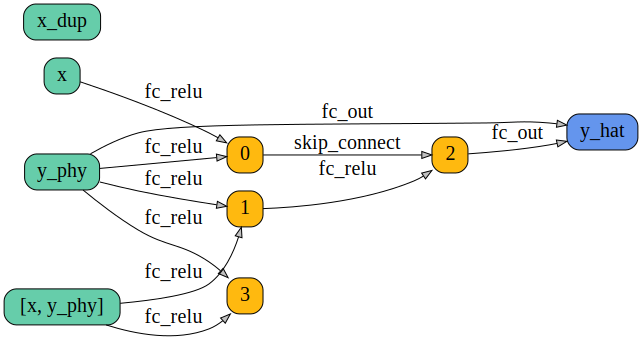

In [7]:
plot_genotype(best_genotype)